# Initialization

## Importing VPython

Import the class vector from vpythons module visual (or in this case vpython which is used for this notebook)

In [71]:
import numpy as np
import pandas as pd
import matplotlib.pylab as plt

class vector(object):
    def __init__(self,x,y,z):
        self._vec = np.array([x,y,z])
    @property
    def mag(self):
        return np.sqrt(np.dot(self._vec,self._vec))
    def __add__(self, other):
        x, y, z = list(self._vec+other._vec)
        return vector(x,y,z)
    def __mul__(self, other):
        x, y, z = list(self._vec*other)
        return vector(x,y,z)
    def __rmul__(self, other):
        return self*other
    def __div__(self, other):
        x, y, z = list(self._vec/other)
        return vector(x,y,z)
    def __repr__(self):
        return "vec({0},{1},{2})".format(*self._vec)
    @property
    def x(self):
        return self._vec[0]
    @property
    def y(self):
        return self._vec[1]
    @property
    def z(self):
        return self._vec[2]
    def dot(self, other):
        return np.dot(self._vec,other._vec)
    
v = vector(1,2,4)
print (v+v).mag
v.mag
v*2

9.16515138991


vec(2,4,8)

## Setting up the Problem

Definition of parameters

In [59]:
rM0 = 4.6    # in units of R0 
vM0 = 0.51   # in units of R0/T0
aM  = 0.99   # in units of R0/T0**2 
T   = 88.    # in units of T0
rS  = 3.e-7  # in units of R0

Initialize distance and velocity vectors

In [60]:
vec_rM0 = vector(0, rM0, 0)
vec_vM0 = vector(vM0, 0, 0)

Definition of the time step

In [61]:
dt = 2 * vM0 / aM / 5000

Define a function for the time evolution

In [62]:
def evolve_mercury(vec_rM_old, vec_vM_old, alpha, dt=dt):
    # Compute the strength of the acceleration
    aMS = aM * ( 1 + alpha * rS / vec_rM_old.mag  ) / vec_rM_old.mag**2
    # Multiply by the direction
    vec_aMS = - aMS * ( vec_rM_old / vec_rM_old.mag )
    # Update velocity vector
    vec_vM_new = vec_vM_old + vec_aMS * dt
    # Update position vector
    vec_rM_new = vec_rM_old + vec_vM_new * dt
    # Return the new vectors
    return vec_rM_new, vec_vM_new

def evolve_mercury_I(vec_rM_old, vec_vM_old, alpha, dt=dt):
    # Update position vector
    vec_rM_new = vec_rM_old + vec_vM_old * dt
    # Compute the strength of the acceleration
    aMS = aM * ( 1 + alpha * rS / vec_rM_new.mag  ) / vec_rM_new.mag**2
    # Multiply by the direction
    vec_aMS = - aMS * ( vec_rM_new / vec_rM_new.mag )
    # Update velocity vector
    vec_vM_new = vec_vM_old + vec_aMS * dt
    # Return the new vectors
    return vec_rM_new, vec_vM_new

# Computation

## Oscillation

In [77]:
dt0    = 2. * vM0 / aM / 10
alpha  = 0.

vec_rMl = [vec_rM0]
vec_vMl = [vec_vM0]

t = 0

while t < TMax:
    vec_rM, vec_vM = evolve_mercury_I(vec_rMl[-1], vec_vMl[-1], alpha, dt=dt)
    vec_rMl.append(vec_rM)
    vec_vMl.append(vec_vM)
    t+=dt0

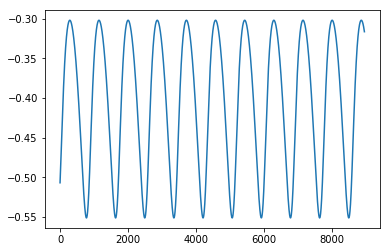

In [95]:
x    = np.array([vec.x for vec in vec_rMl  ])
y    = np.array([vec.y for vec in vec_rMl  ])
mag  = np.array([vec.mag for vec in vec_rMl])
vmag = np.array([vec.mag for vec in vec_vMl])
#plt.plot(x,y))
plt.plot((mag[1:]-mag[:-1])/dt0-vmag[1:])
plt.show()

## Farm $\delta \theta$

In [63]:
import numpy as np


In [64]:
alphas = np.linspace(0, 1.e4, 11)
dt0    = 2 * vM0 / aM
dts    = dt0  / np.array([1,2,5,10])

In [65]:
data = []

TMax = T*10.5


for alpha in alphas:
    for dt in dts:
        
        vec_rM = vec_rM0
        vec_vM = vec_vM0
        
        rprev   = [vec_rM0*(1./3), vec_rM0*(1./2), vec_rM0]
        ph_last = vec_rM0
        
        t     = 0
        turn  = 0
    
        while t < TMax:
            vec_rM, vec_vM = evolve_mercury_I(vec_rM, vec_vM, alpha, dt=dt)
            rprev.pop(0)
            rprev.append(vec_rM)
            
            if rprev[0].mag > rprev[1].mag and rprev[1].mag < rprev[2].mag:
                dtheta = np.arccos( rprev[1].dot(ph_last) /  rprev[1].mag / ph_last.mag  )/2/np.pi*360
                data.append({
                    #"dt"     : dt,
                    "alpha"  : alpha,
                    "dtfact" : dt0/dt,
                    "turn"   : turn,
                    "dtheta" : dtheta,
                    "t"      : t
                })
                ph_last = rprev[1]
                turn += 1
        
            t = t + dt

frame = pd.DataFrame(data)
#frame.set_index(["alpha","dtfact"], inplace=True)
print frame.shape
frame.head()

(440, 5)


alpha  dtfact     dtheta           t  turn
0    0.0     1.0  17.155780   86.545455     0
1    0.0     1.0   2.697430  176.181818     1
2    0.0     1.0   3.941011  264.787879     2
3    0.0     1.0   2.697432  354.424242     3
4    0.0     1.0   3.941010  443.030303     4

In [69]:
frame.query("alpha == 0 and dtfact == 1.0")

alpha  dtfact     dtheta           t  turn
0    0.0     1.0  17.155780   86.545455     0
1    0.0     1.0   2.697430  176.181818     1
2    0.0     1.0   3.941011  264.787879     2
3    0.0     1.0   2.697432  354.424242     3
4    0.0     1.0   3.941010  443.030303     4
5    0.0     1.0   2.697428  532.666667     5
6    0.0     1.0   3.941001  621.272727     6
7    0.0     1.0   2.697416  710.909091     7
8    0.0     1.0   3.940986  799.515152     8
9    0.0     1.0   2.697399  889.151515     9

In [15]:
frame.to_csv("mercury_shift_I.dat")

## Plotting

In [19]:
import seaborn as sns
import matplotlib.pylab as plt
sns.set(style="whitegrid", font="Source Sans Pro", font_scale=1.4)

### Zero Precession

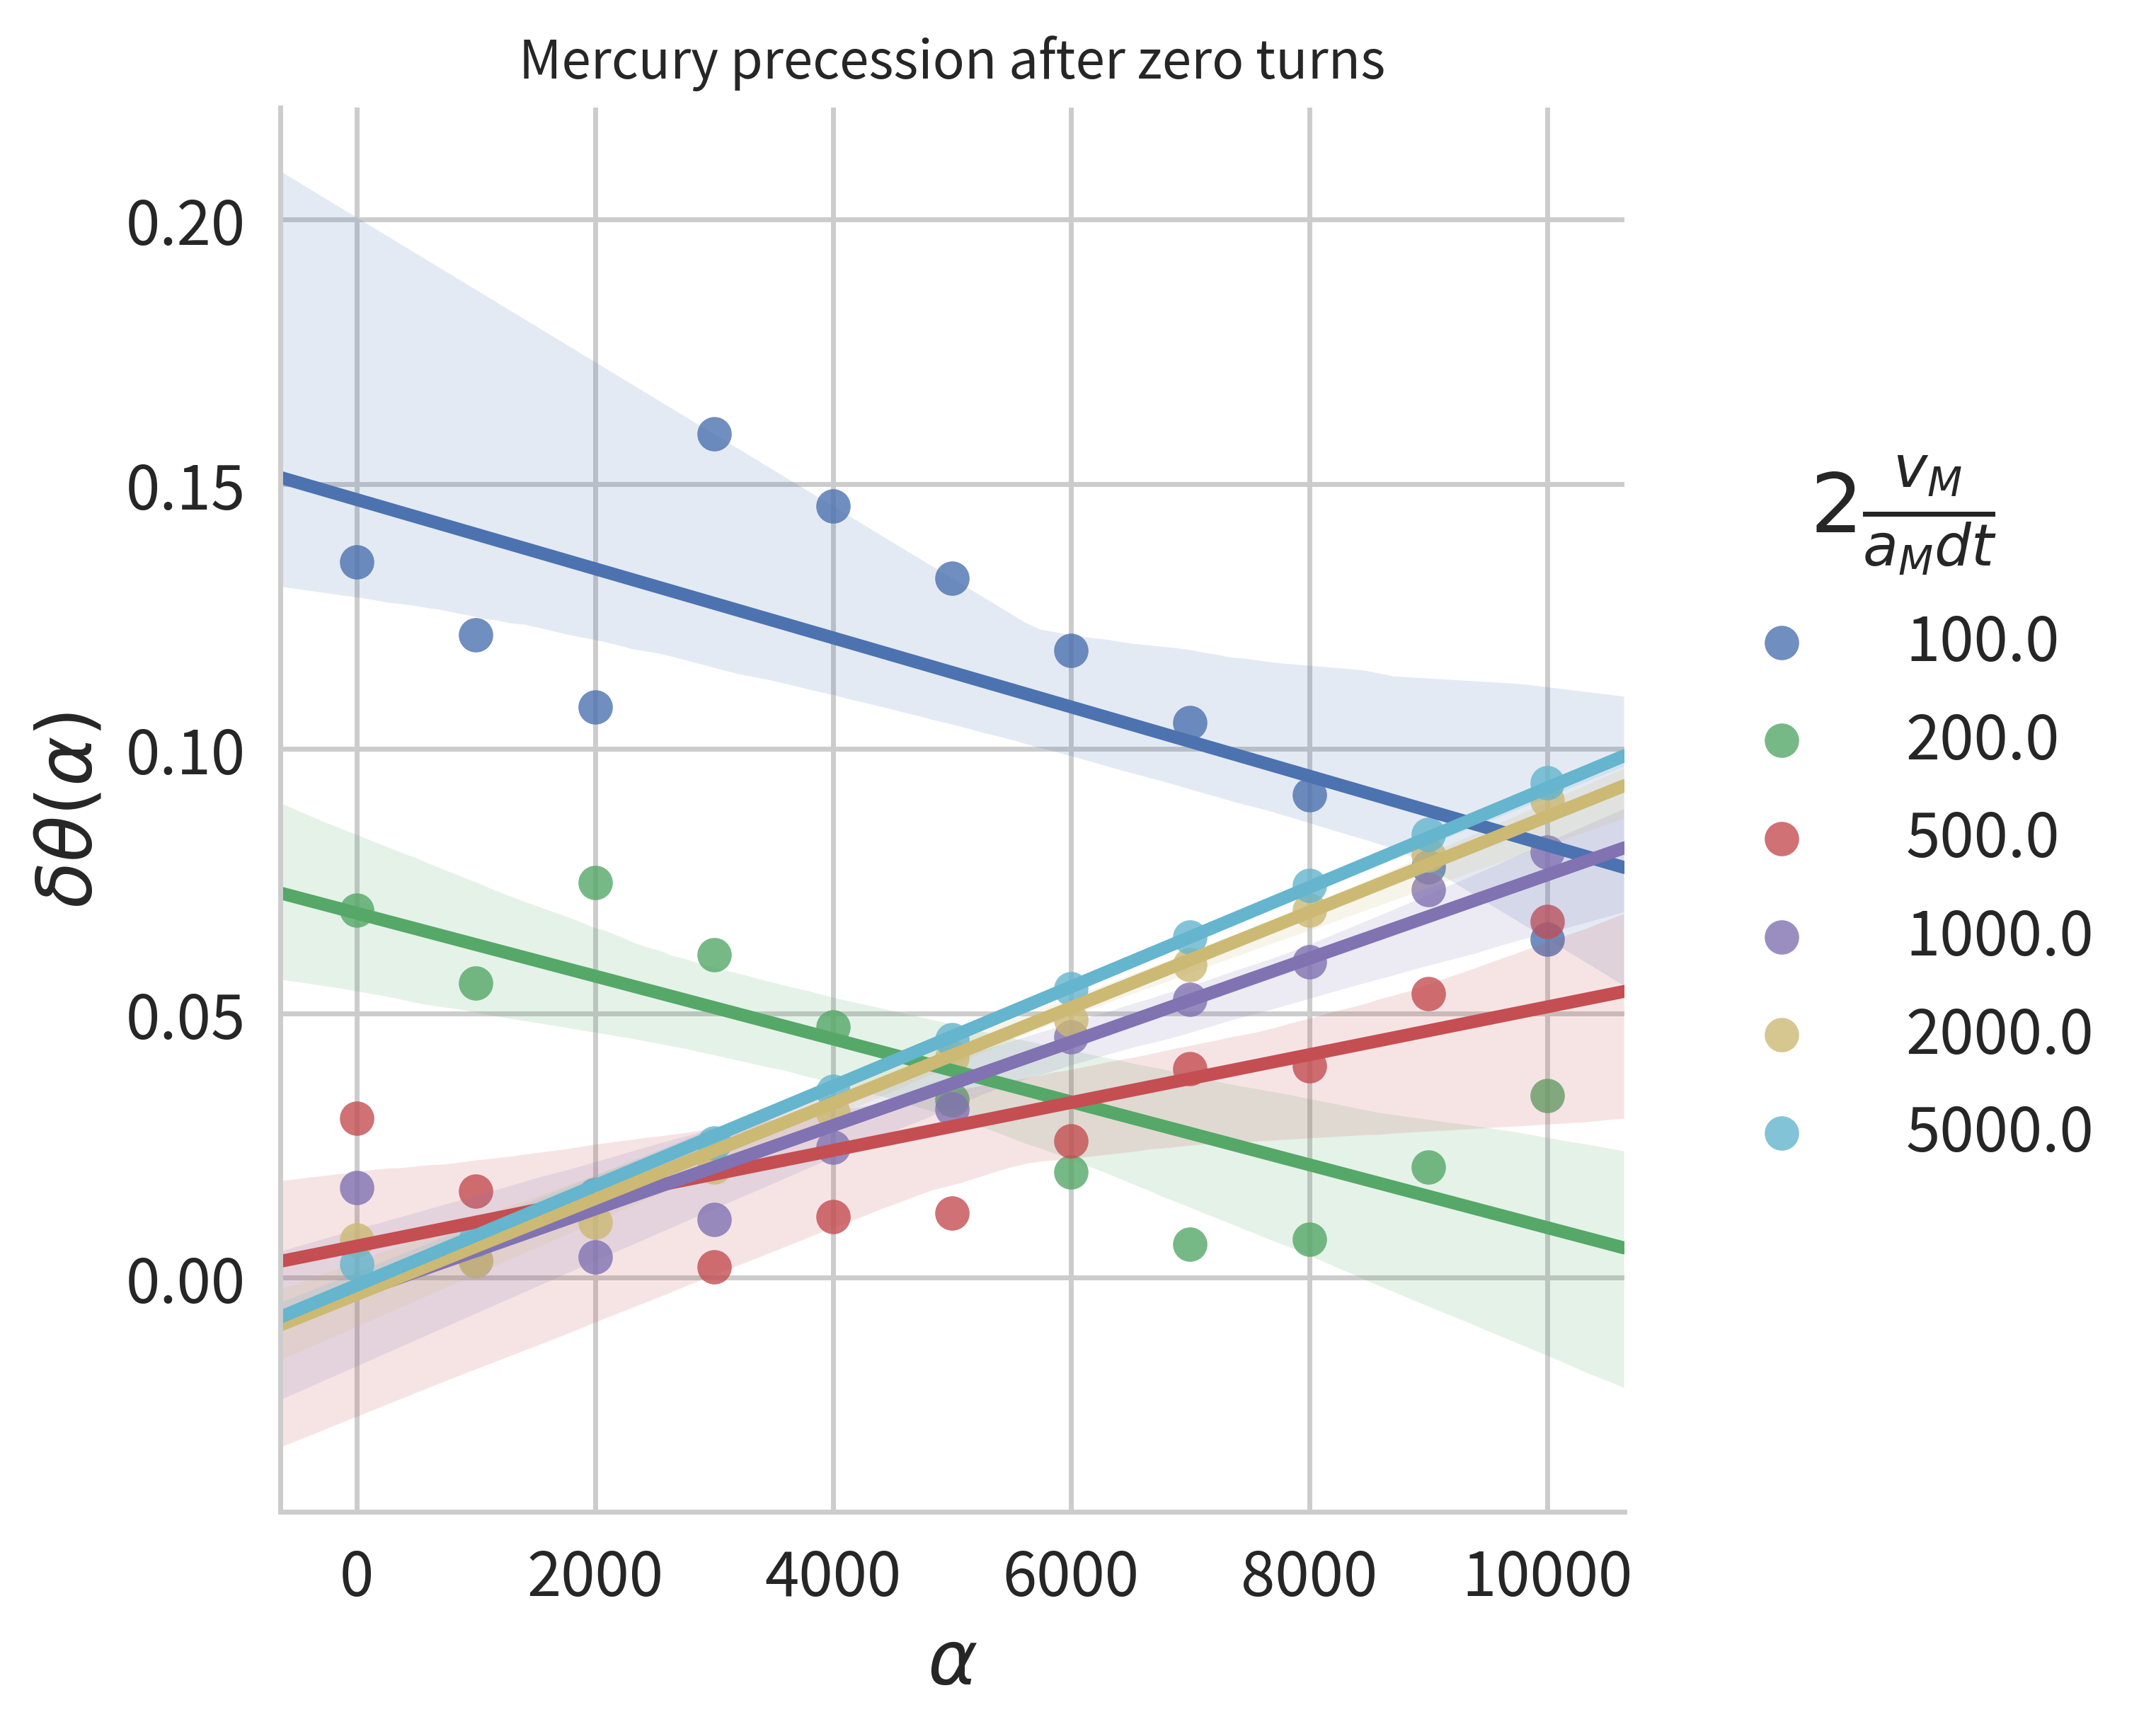

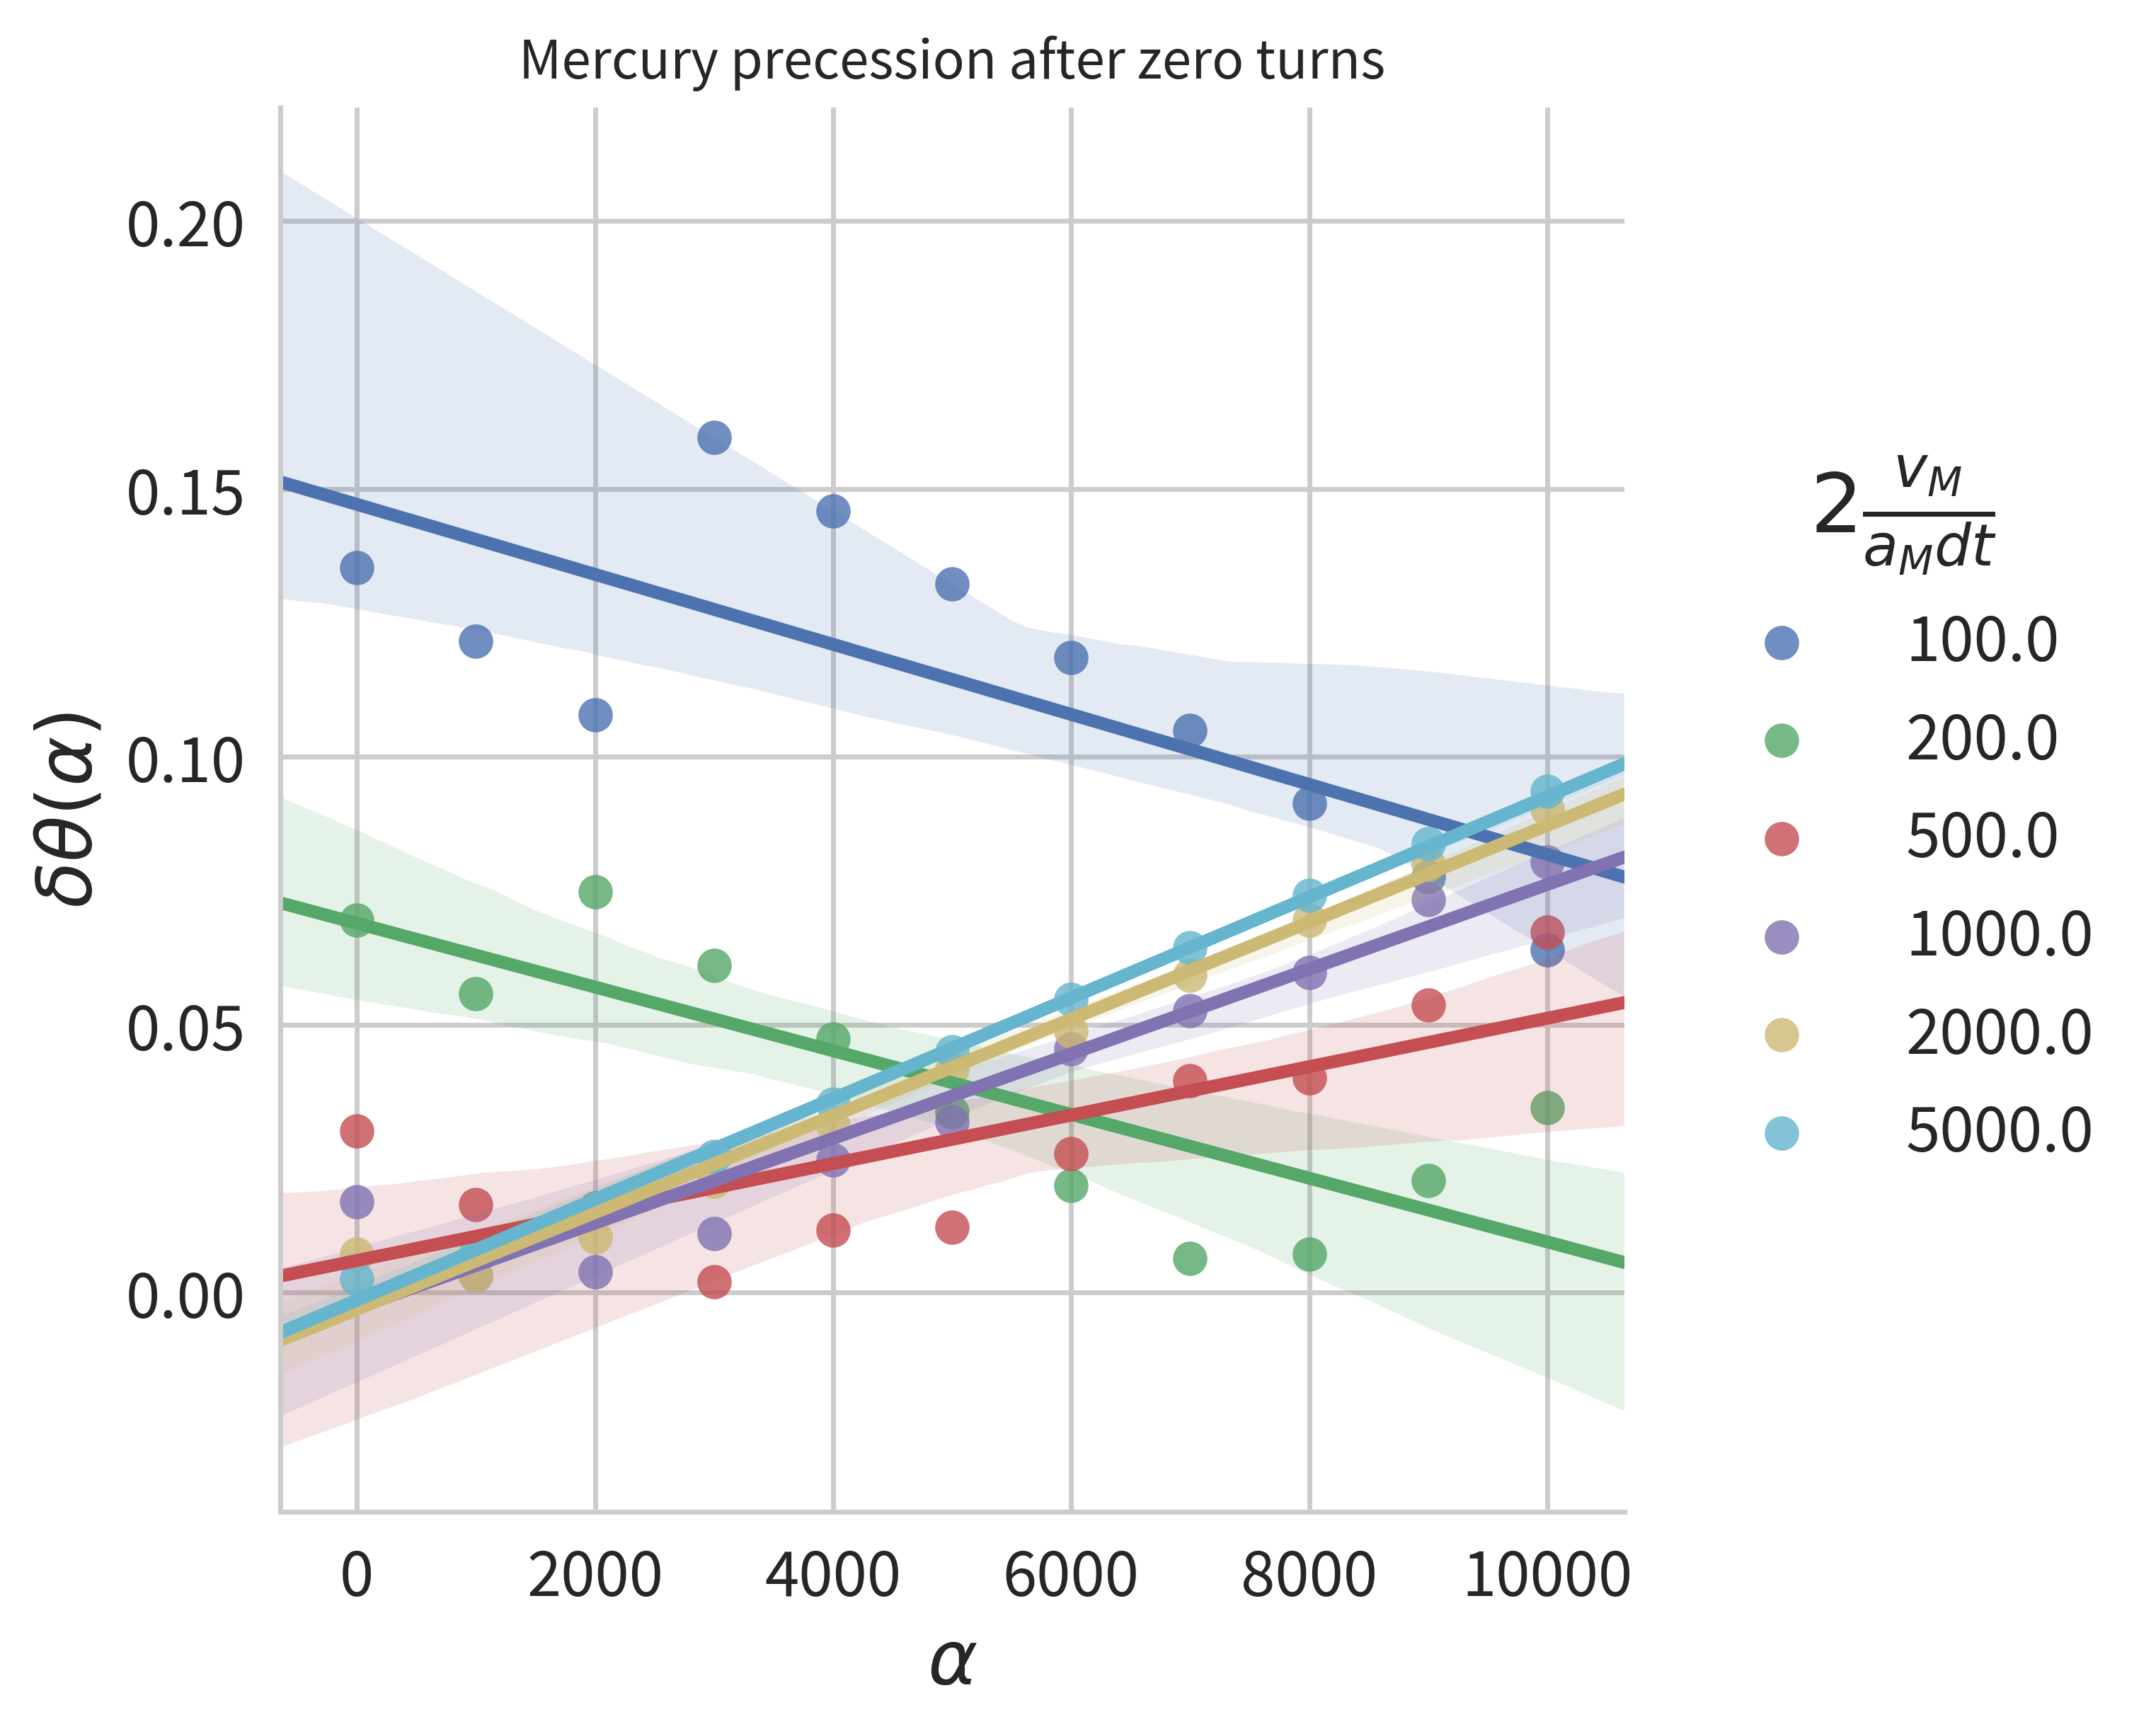

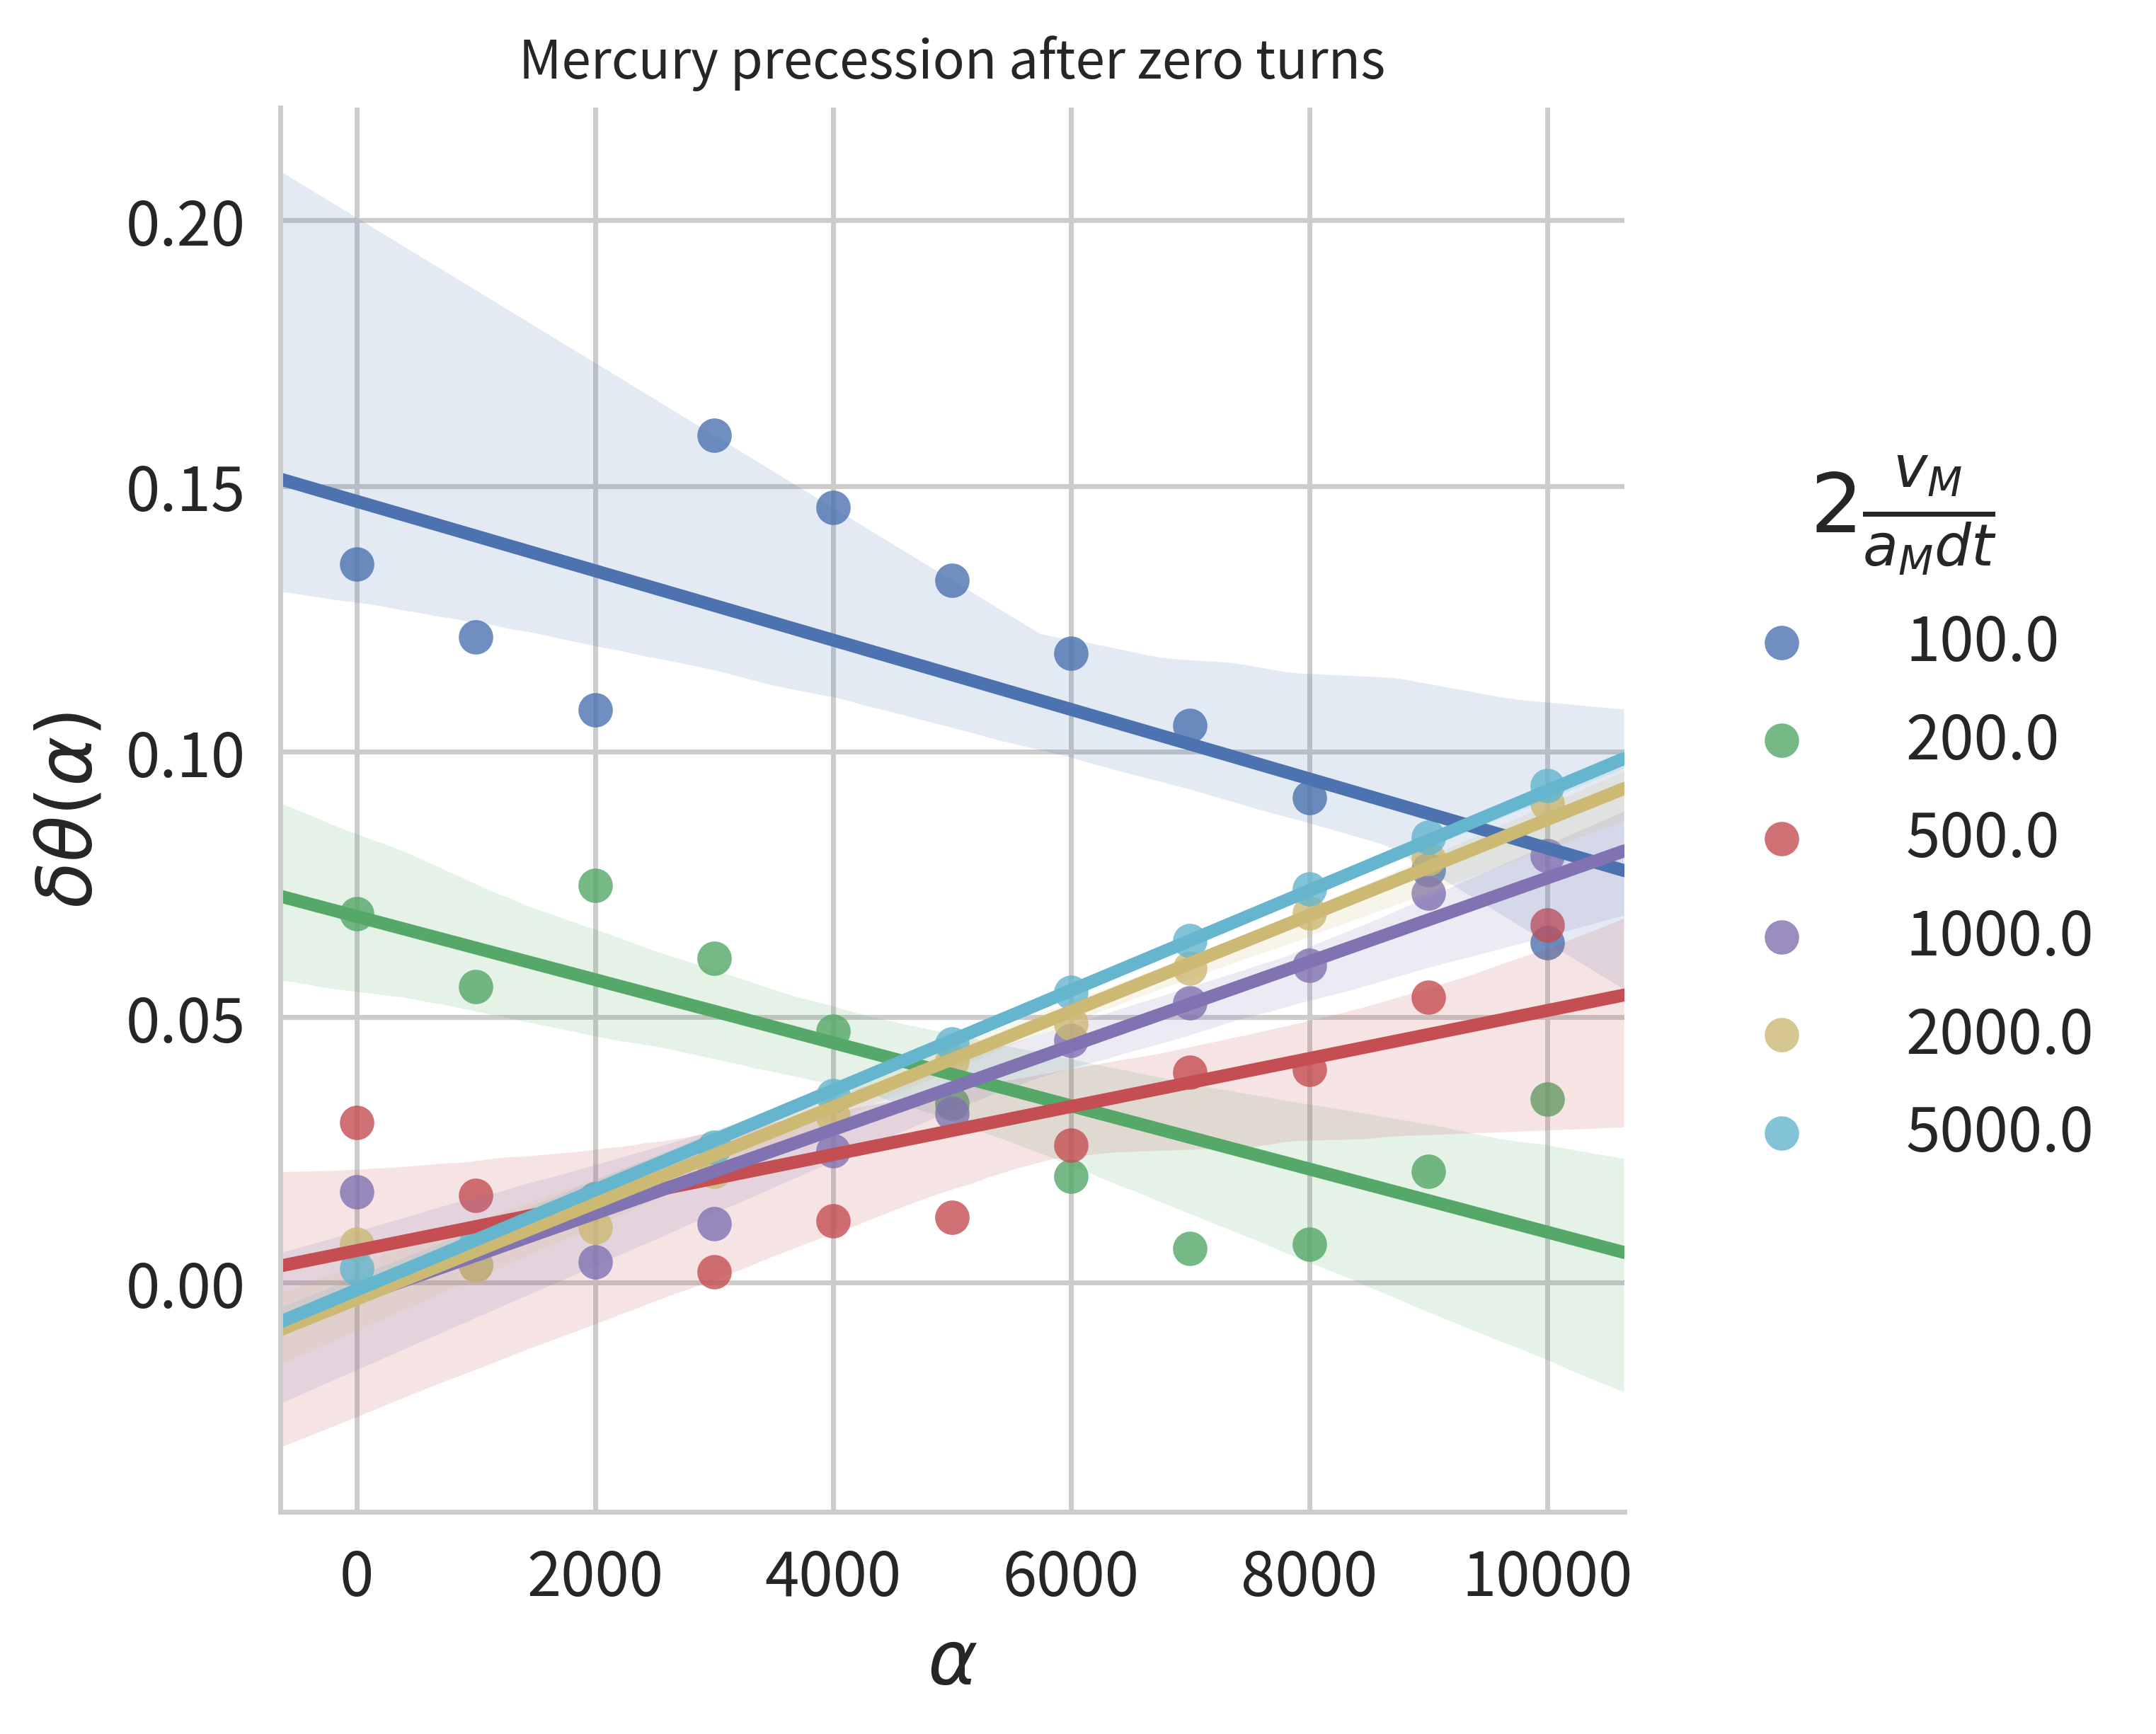

In [20]:
tf = frame.query("turn == 0")

graph = sns.lmplot(data=tf, hue="dtfact", y="dtheta", x="alpha", legend=False)

graph.fig.set_dpi(500)
graph.fig.set_size_inches(5,5)

graph.set_axis_labels(r"$\alpha$",r"$\delta\theta(\alpha)$")
ax = graph.fig.gca()
ax.set_title("Mercury precession after zero turns", fontdict={"size": 12})

ax.legend(loc="center left", bbox_to_anchor=(1.02, 0.5), title=r"$2\frac{v_M}{a_M dt}$")


plt.show(graph)

In [93]:
graph.savefig("initial_time_shift.pdf", bbox_inches="tight")

### Angular Growth

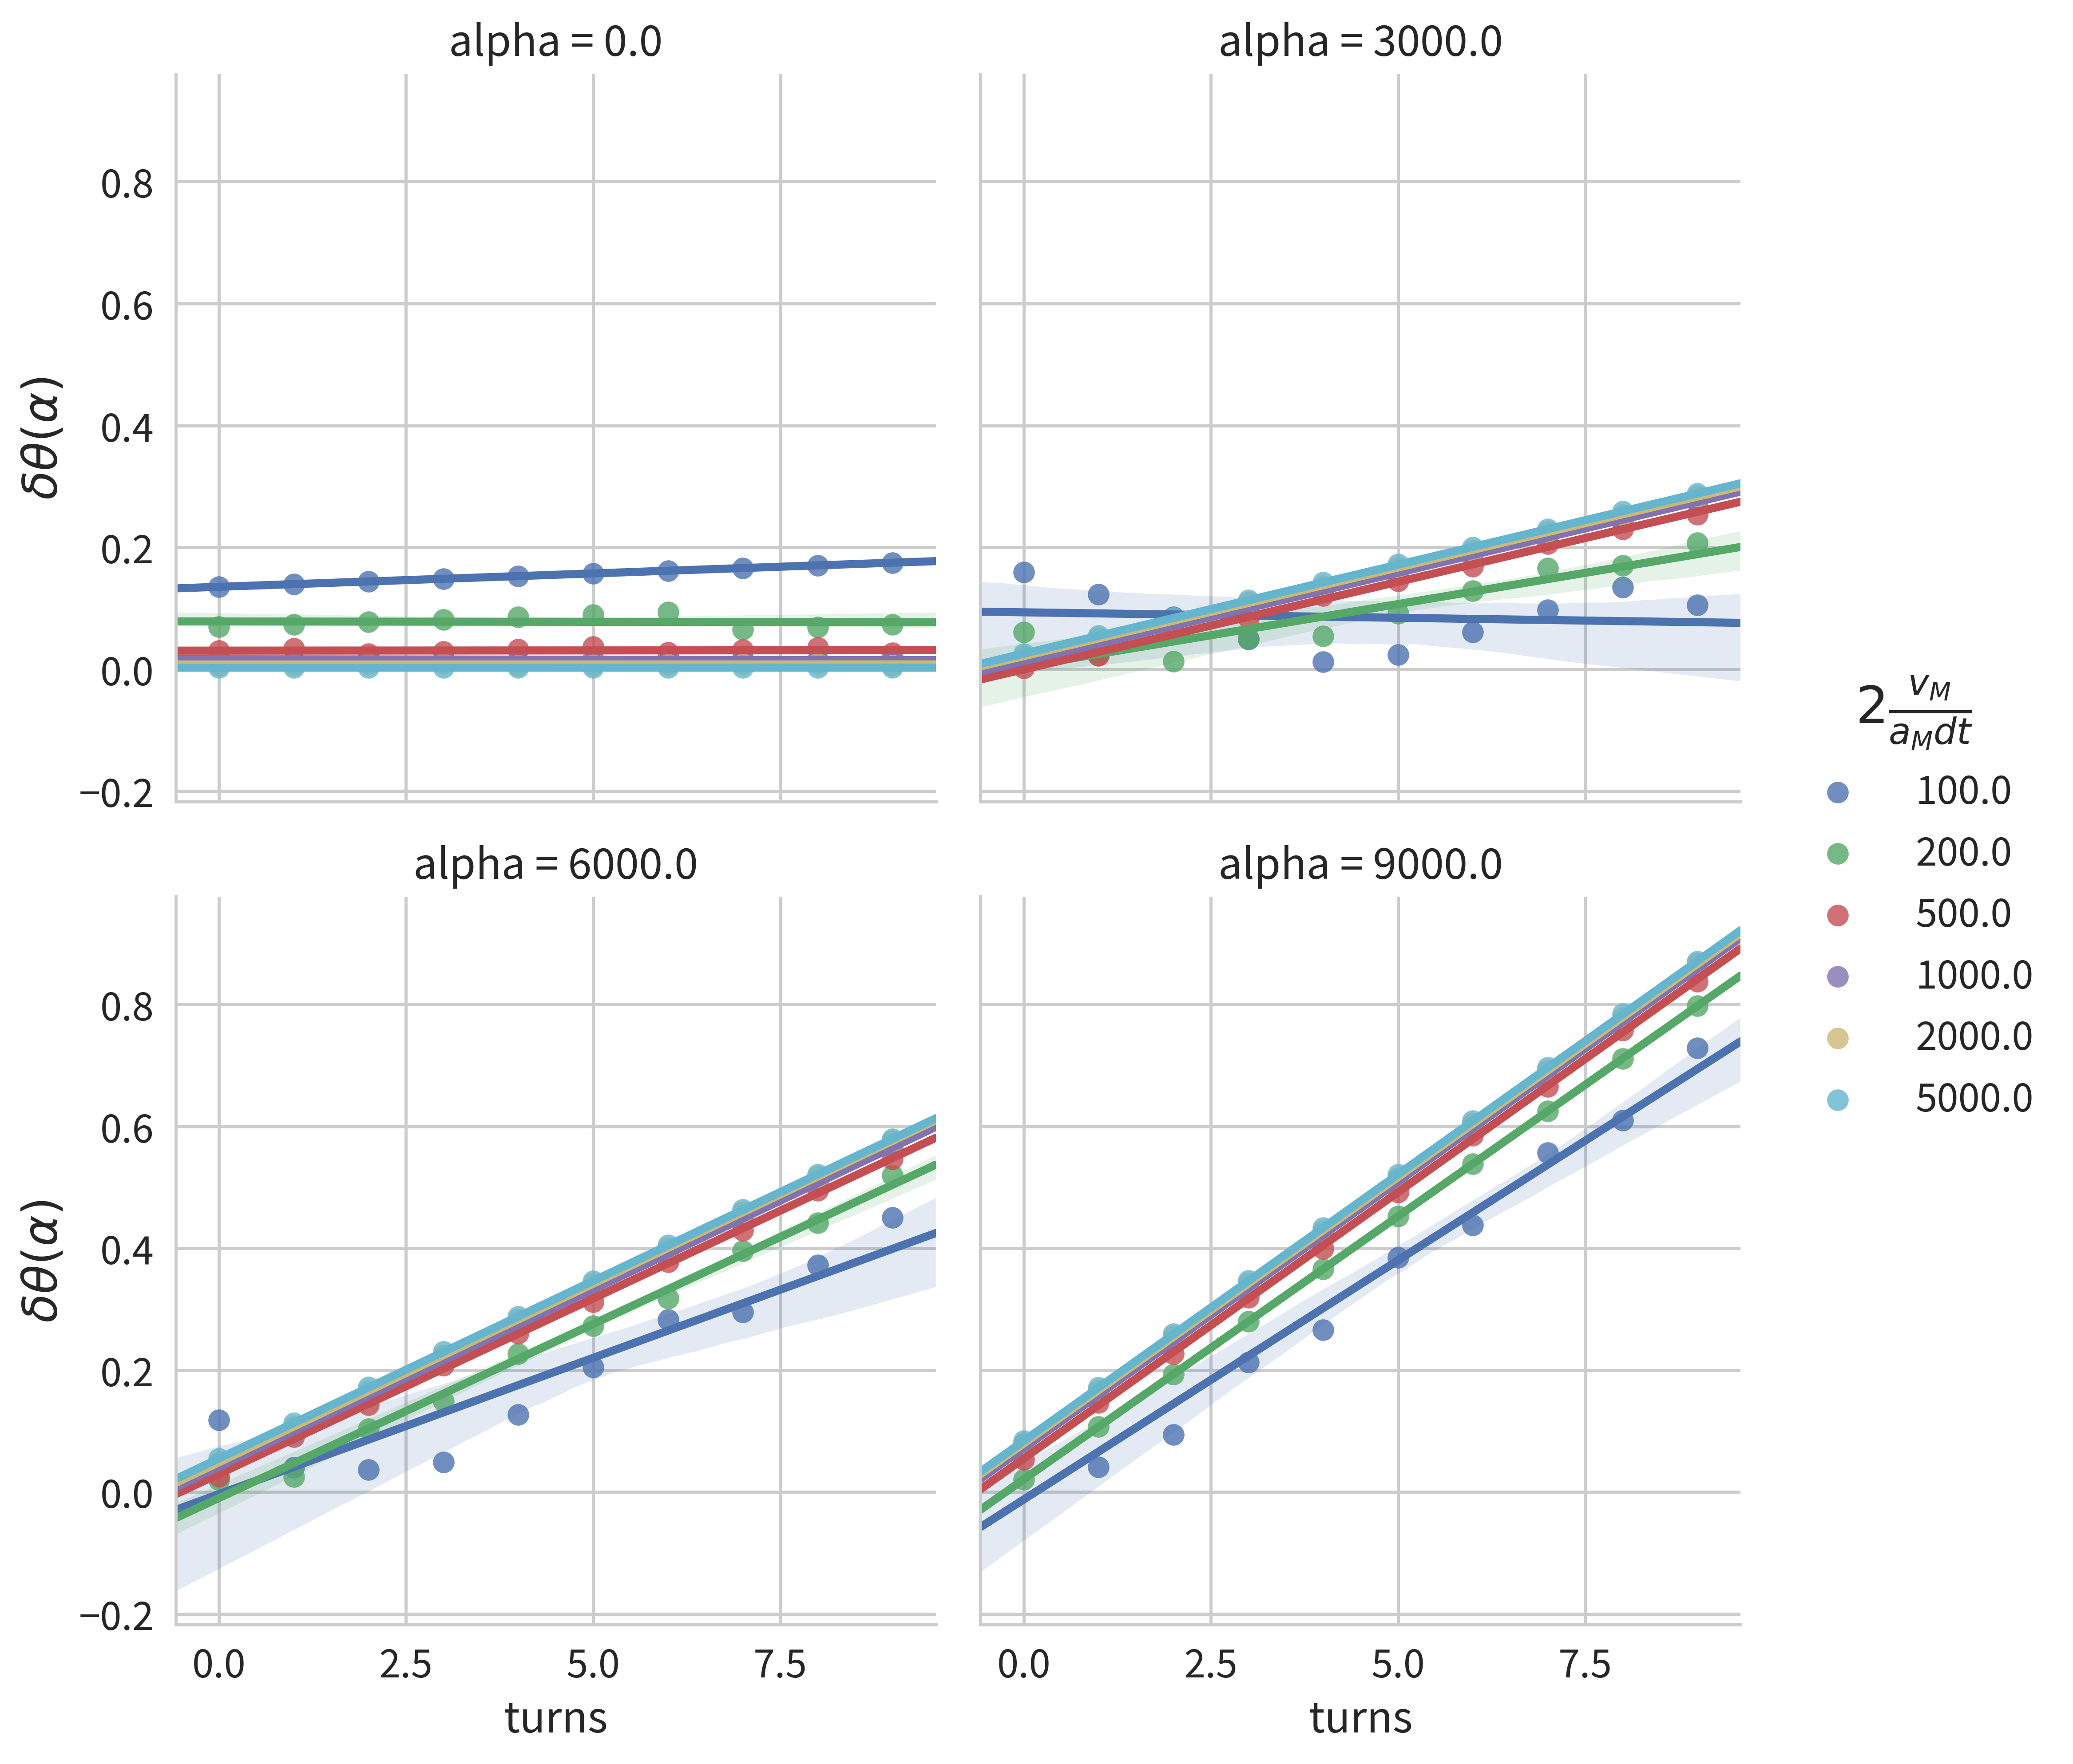

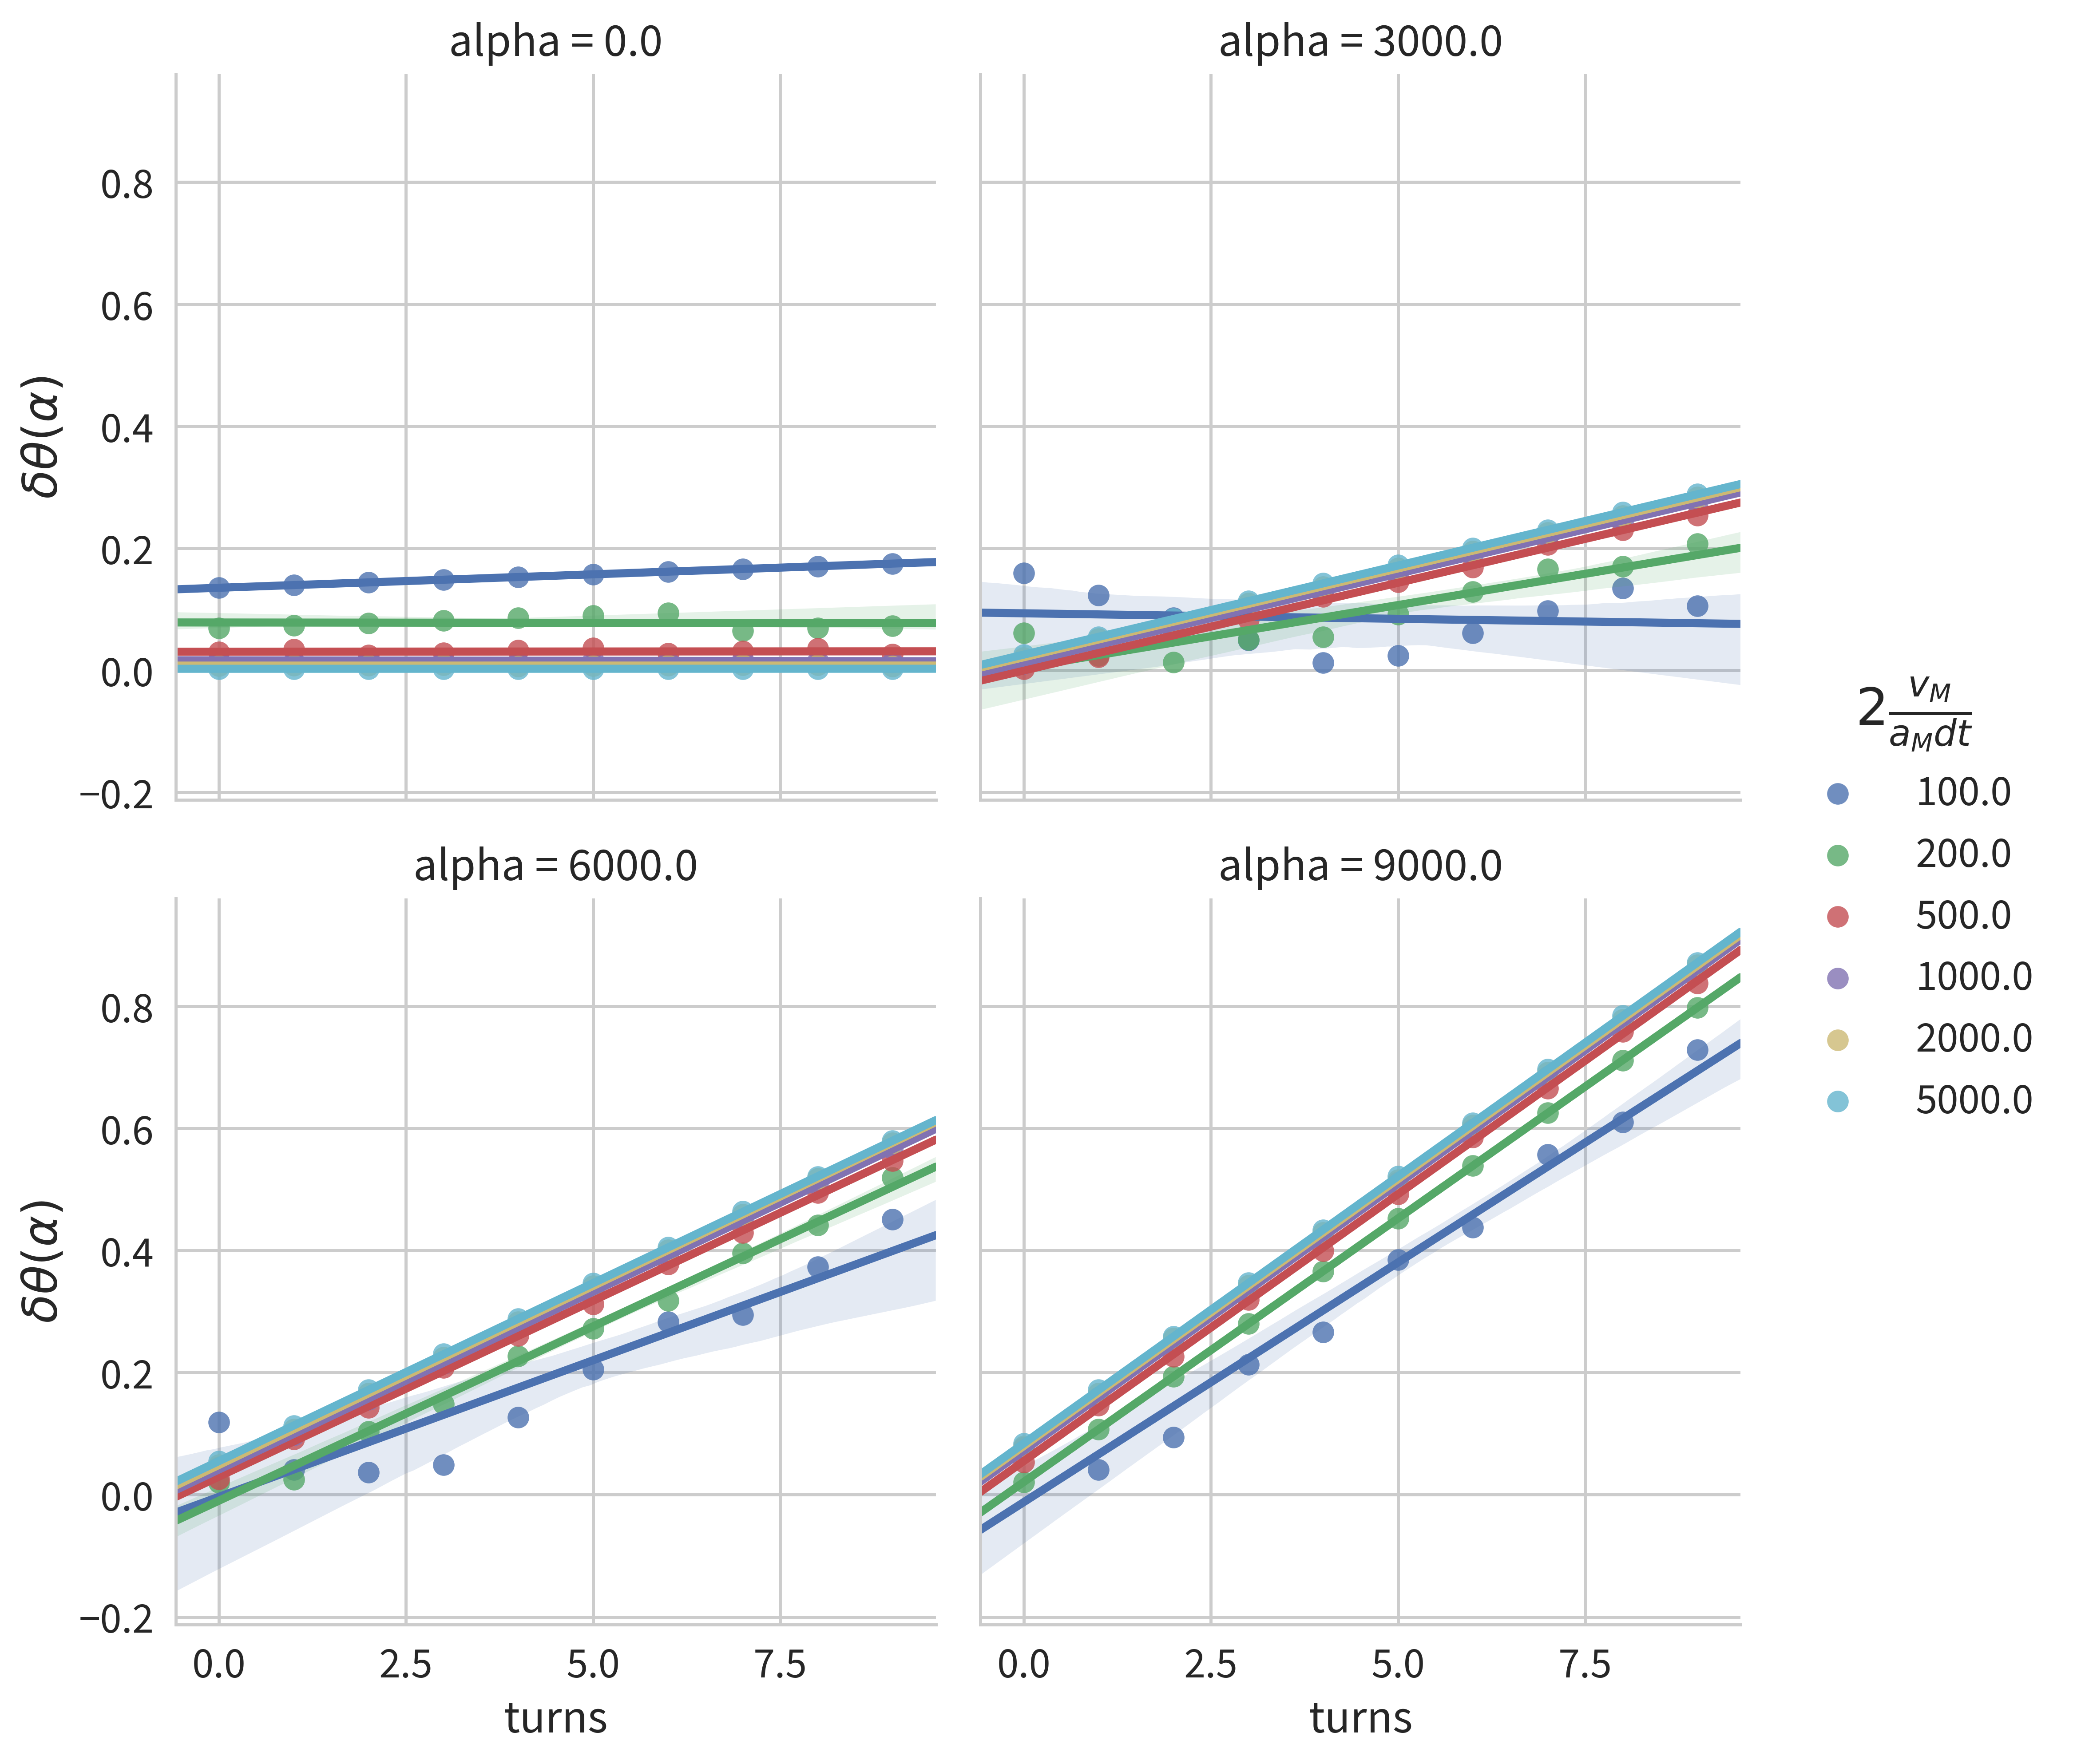

In [22]:
query = " or ".join(["alpha == {0}".format(el) for el in frame.alpha.unique()[::3]])
tf = frame.query(query)

graph = sns.lmplot(data=tf, x="turn", y="dtheta", hue="dtfact", legend=False, col="alpha", col_wrap=2)

graph.fig.set_dpi(500)
graph.fig.set_size_inches(8,8)

graph.set_axis_labels(r"turns",r"$\delta\theta(\alpha)$")
ax = graph.fig.gca()
#ax.set_title("Mercury precession after zero turns", fontdict={"size": 12})

ax.legend(loc="center left", bbox_to_anchor=(1.02, 1.), title=r"$2\frac{v_M}{a_M dt}$")


plt.show(graph)

In [114]:
graph.savefig("precession_growth.pdf", bbox_inches="tight")

### $\alpha$ Dependence

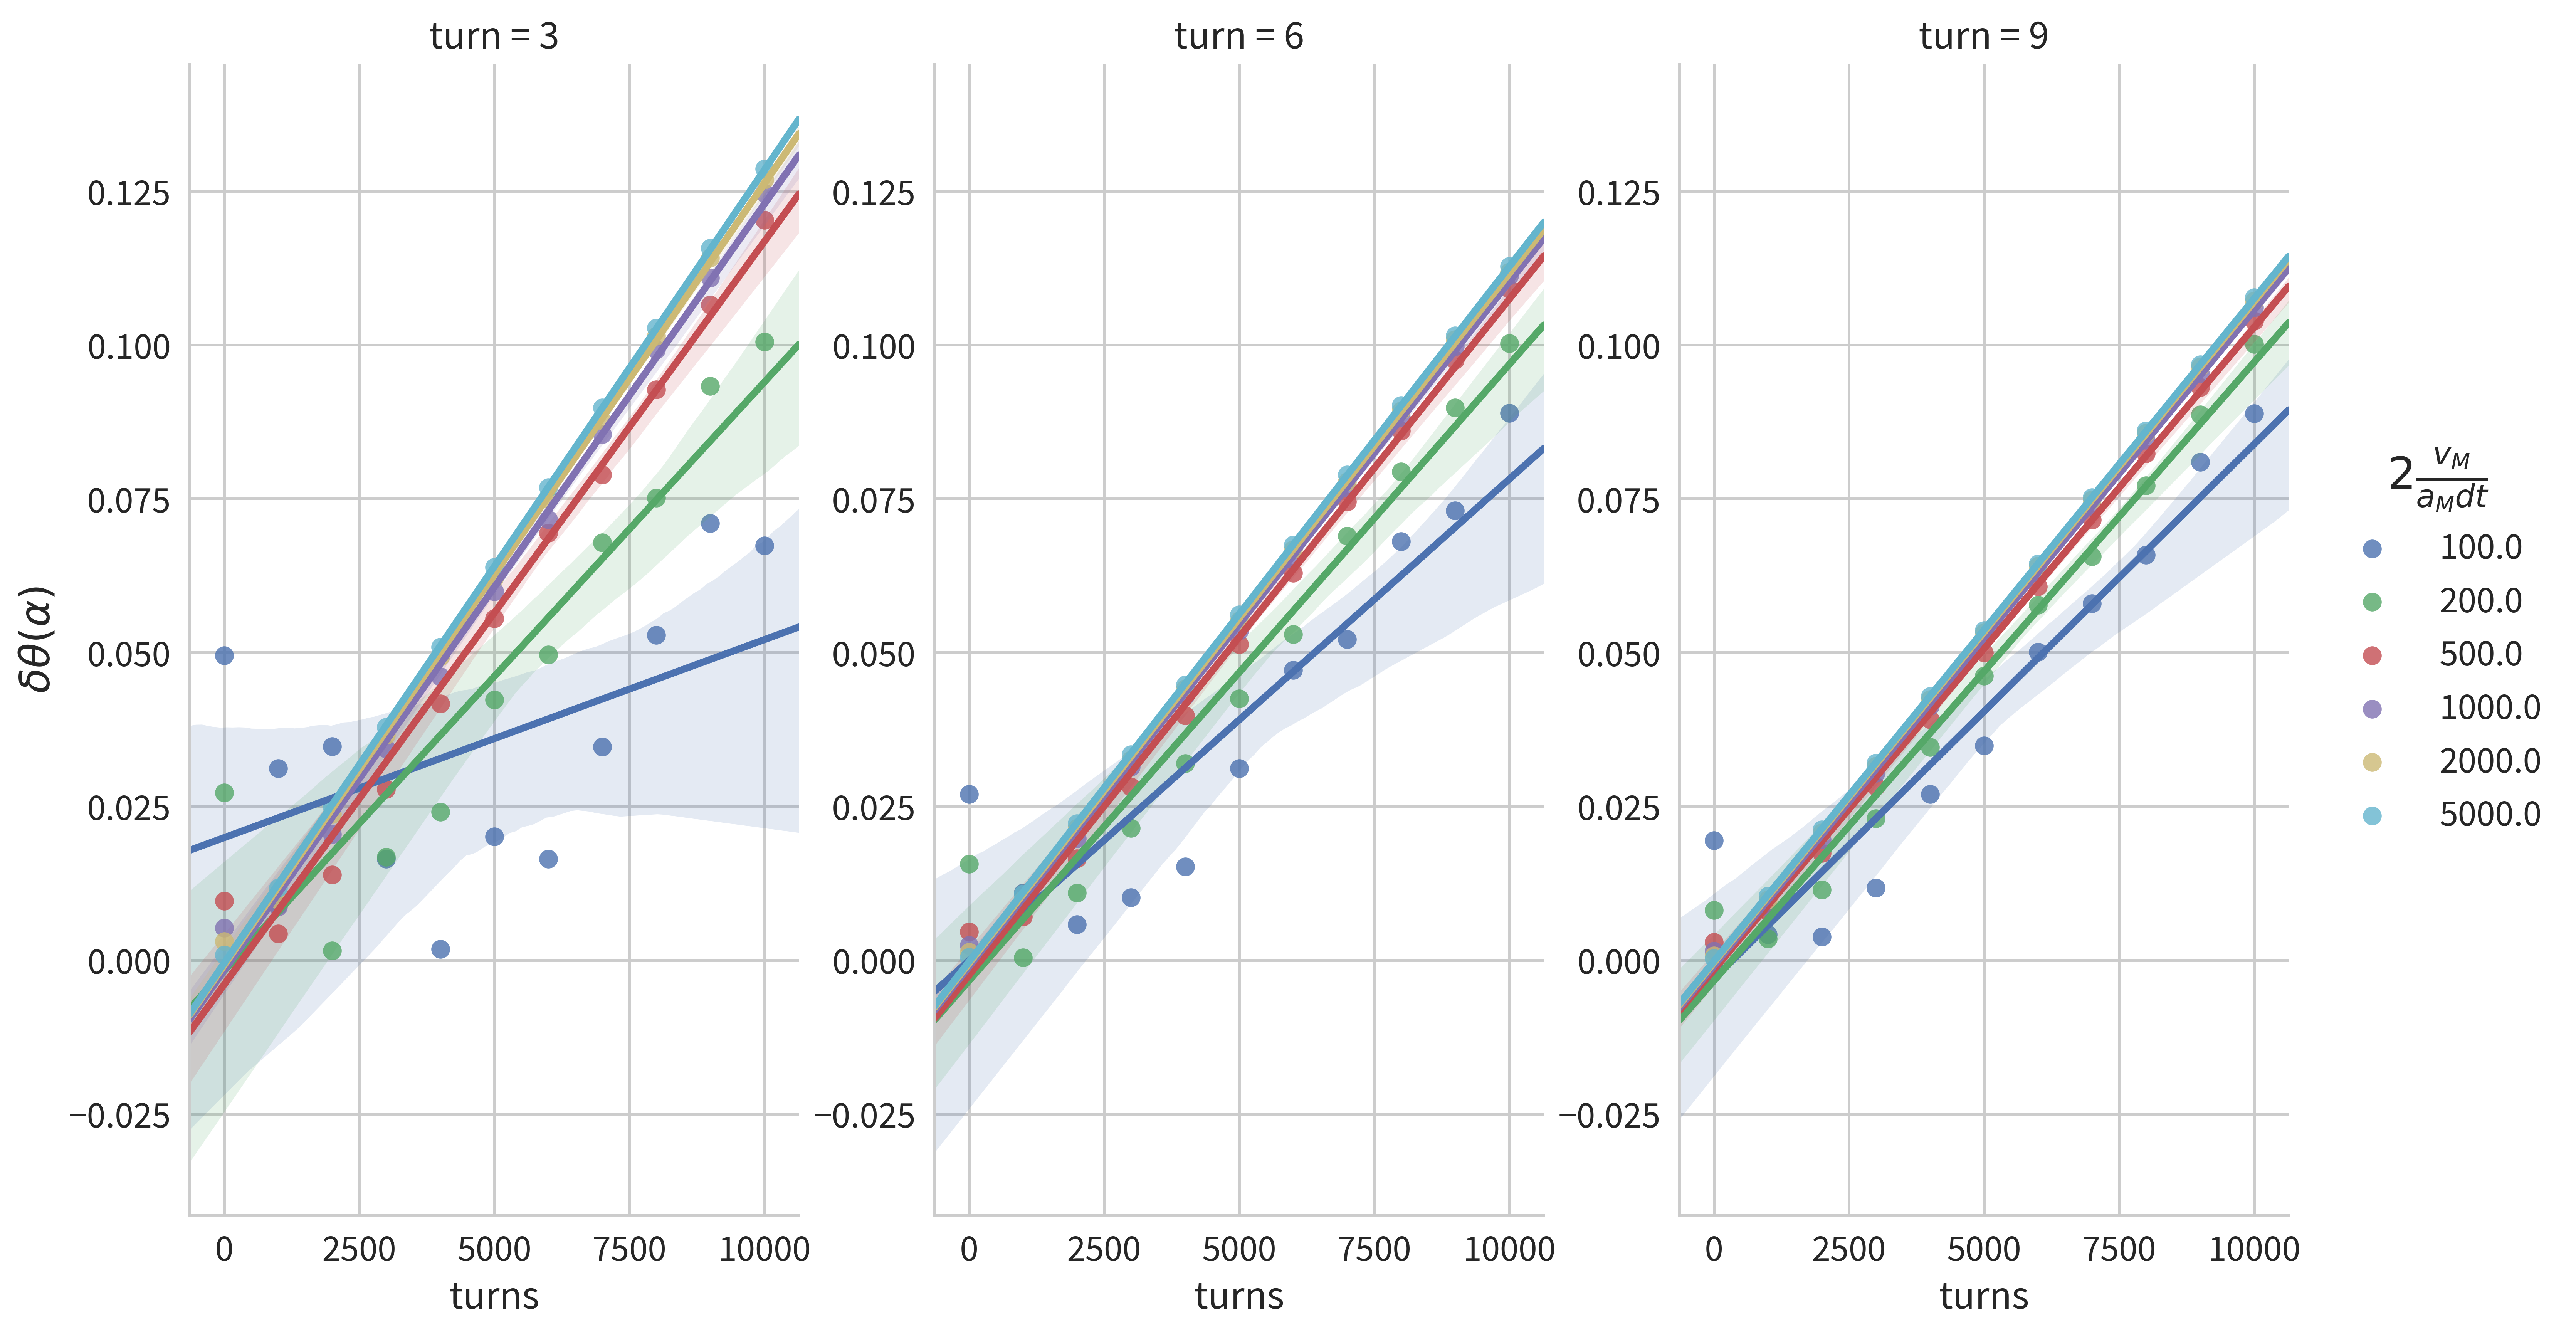

In [23]:
query = " or ".join(["turn == {0}".format(el) for el in frame.turn.unique()][::3])
tf = frame.query("turn > 0").query(query).copy()
tf["dthpt"] = tf["dtheta"] / tf["turn"]

graph = sns.lmplot(data=tf, x="alpha", y="dthpt", hue="dtfact", legend=False, col="turn")

graph.fig.set_dpi(500)
graph.fig.set_size_inches(12,8)

graph.set_axis_labels(r"turns",r"$\delta\theta(\alpha)$")
ax = graph.fig.gca()
#ax.set_title("Mercury precession after zero turns", fontdict={"size": 12})

ax.legend(loc="center left", bbox_to_anchor=(1.02, 0.5), title=r"$2\frac{v_M}{a_M dt}$")

plt.show(graph)

In [139]:
graph.savefig("alpha_dependence_0.pdf", bbox_inches="tight")

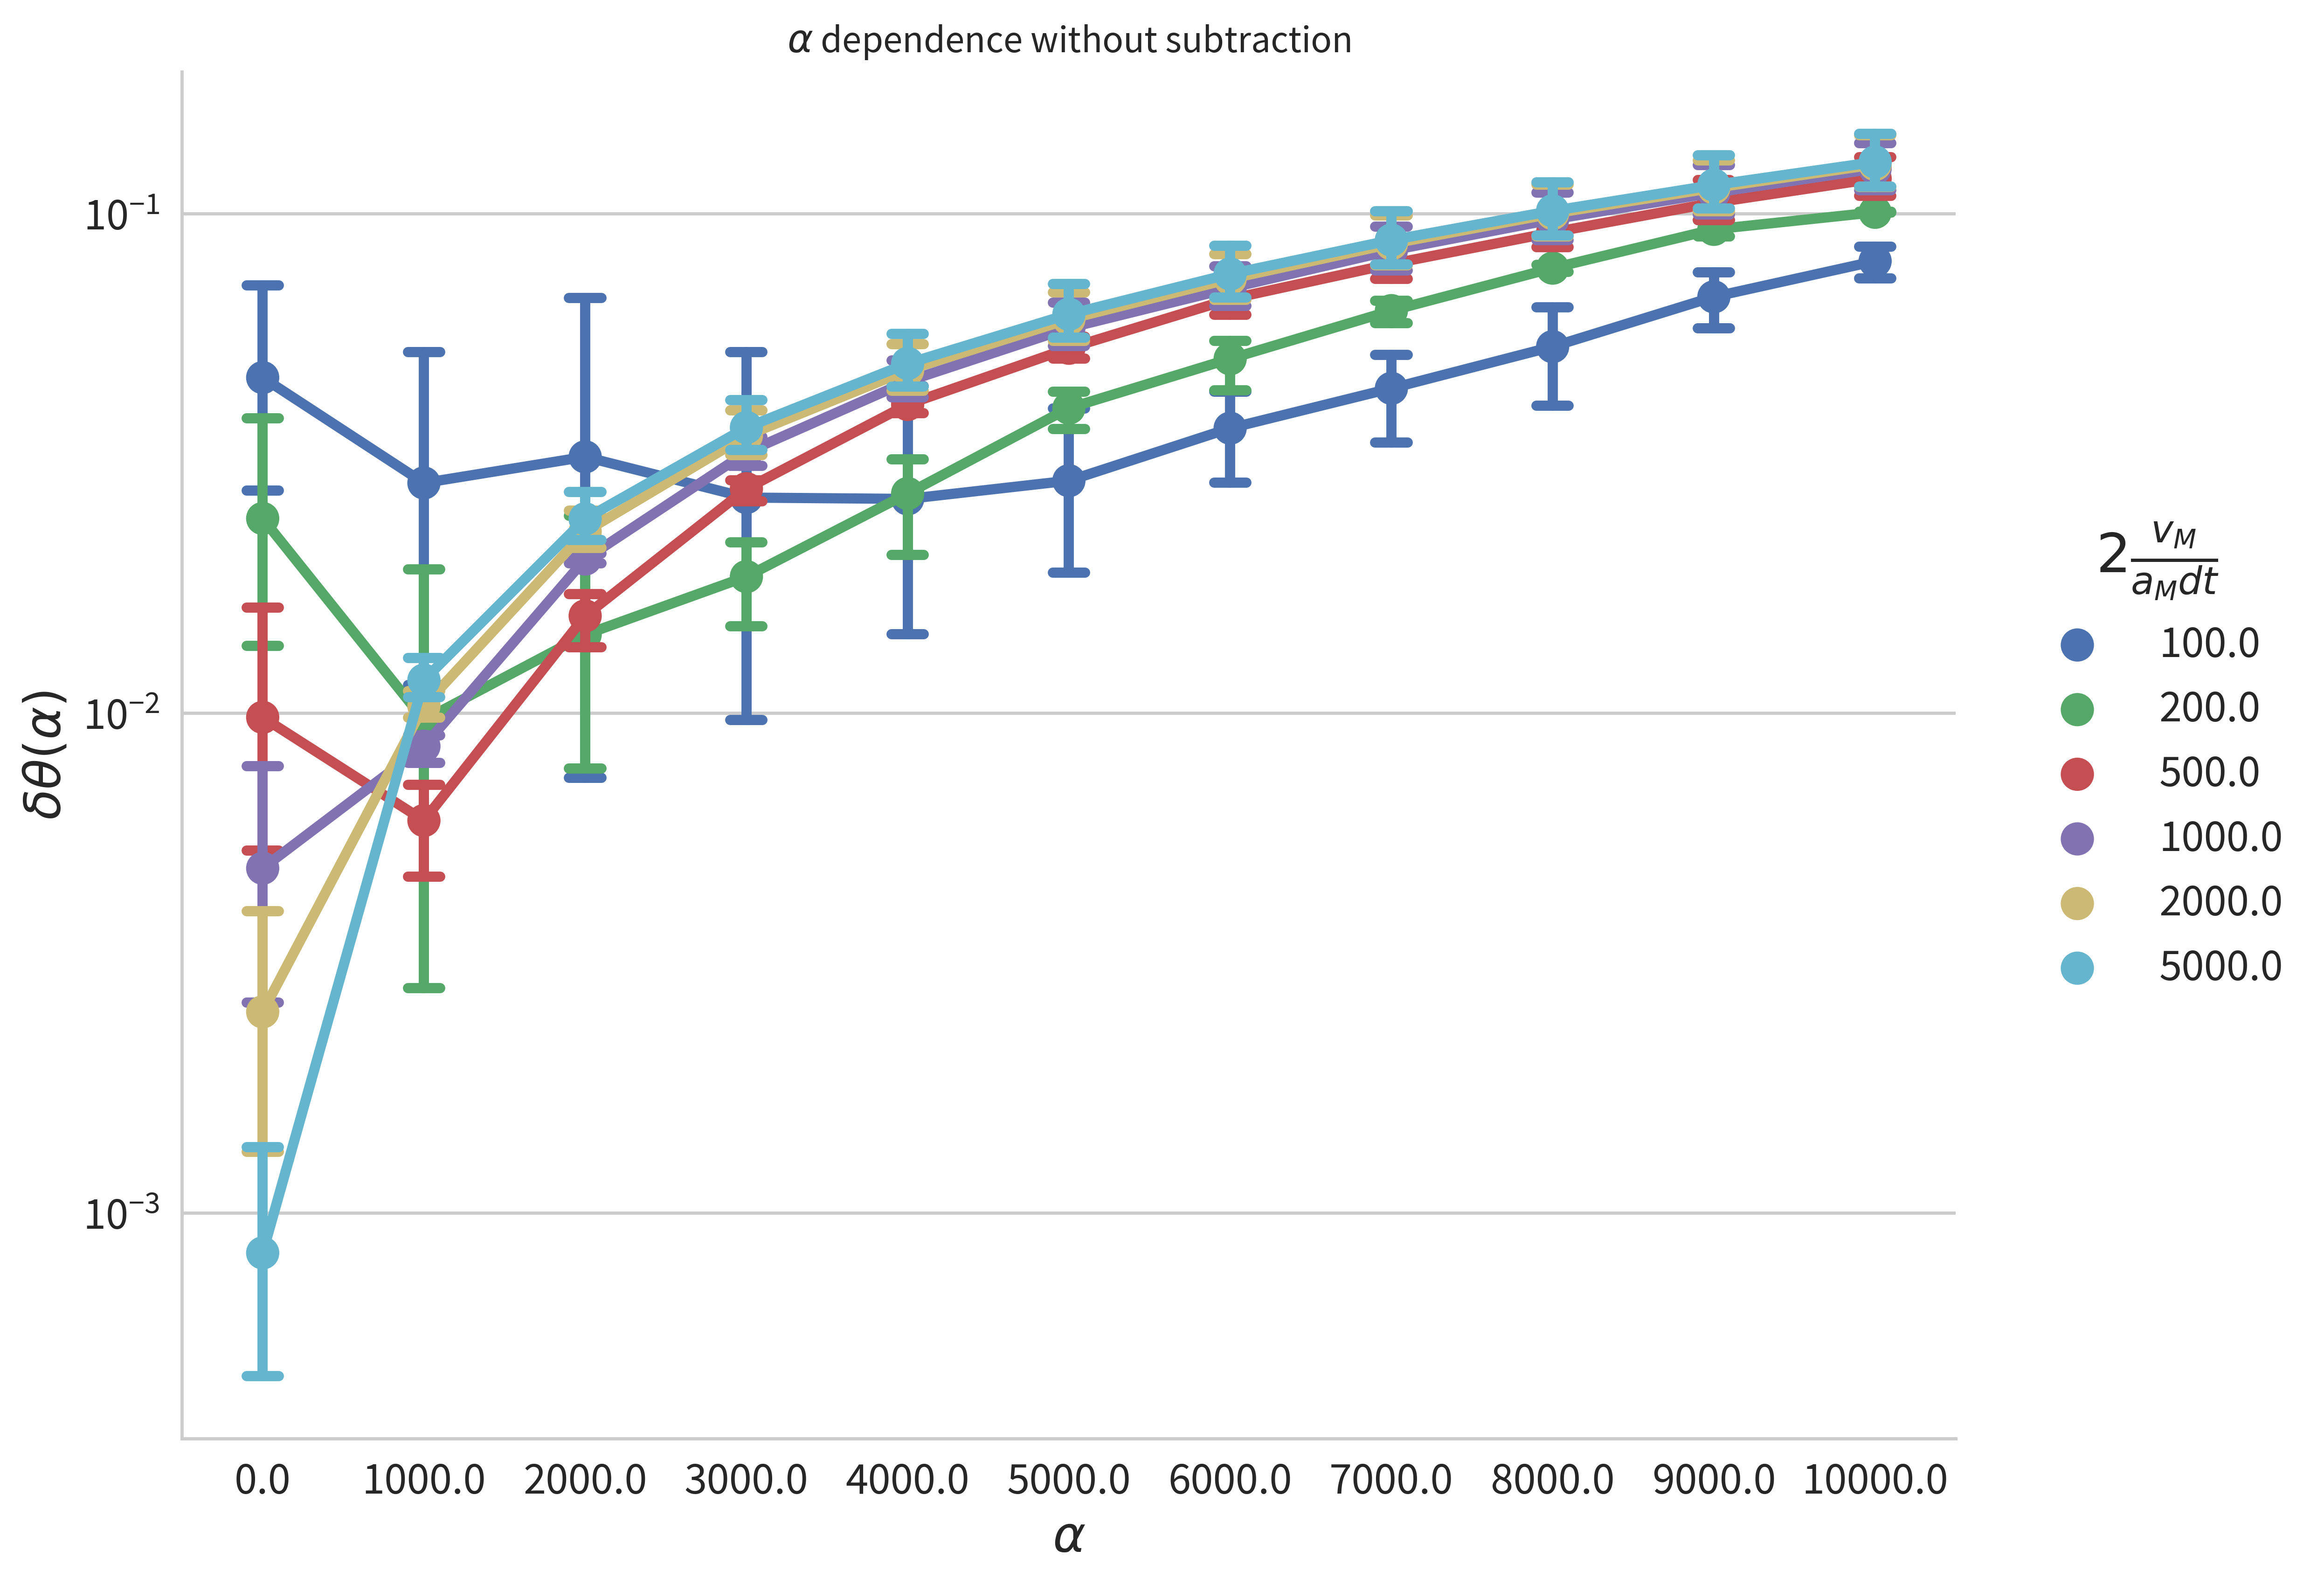

In [24]:
tf = frame.query("turn > 0").copy()
zeroa = frame.query("turn == 0 ")["dtheta"].as_matrix()

for turn in tf.turn.unique():
    ind = tf.query("turn == @turn").index
    tf.loc[ind,"dthpt"] = tf.loc[ind,"dtheta"]/tf.loc[ind,"turn"]# - zeroa
#tf["dthpt"] = tf["dthpt"]/tf["turn"] * 356./88*100 *3600


graph = sns.factorplot(data=tf, x="alpha", y="dthpt", hue="dtfact", legend=False, capsize=.2)

graph.fig.set_dpi(500)
graph.fig.set_size_inches(12,8)

graph.set_axis_labels(r"$\alpha$",r"$\delta\theta(\alpha)$")
ax = graph.fig.gca()
ax.set_title(r"$\alpha$ dependence without subtraction", fontdict={"size": 12})

#ax.set_xlim(-0.1, 2500)
#ax.set_ylim(-4000, 4002)

ax.set_yscale("log")

ax.legend(loc="center left", bbox_to_anchor=(1.02, 0.5), title=r"$2\frac{v_M}{a_M dt}$")

plt.show(graph)

In [276]:
graph.savefig("alpha_dependence_0.pdf", bbox_inches="tight")

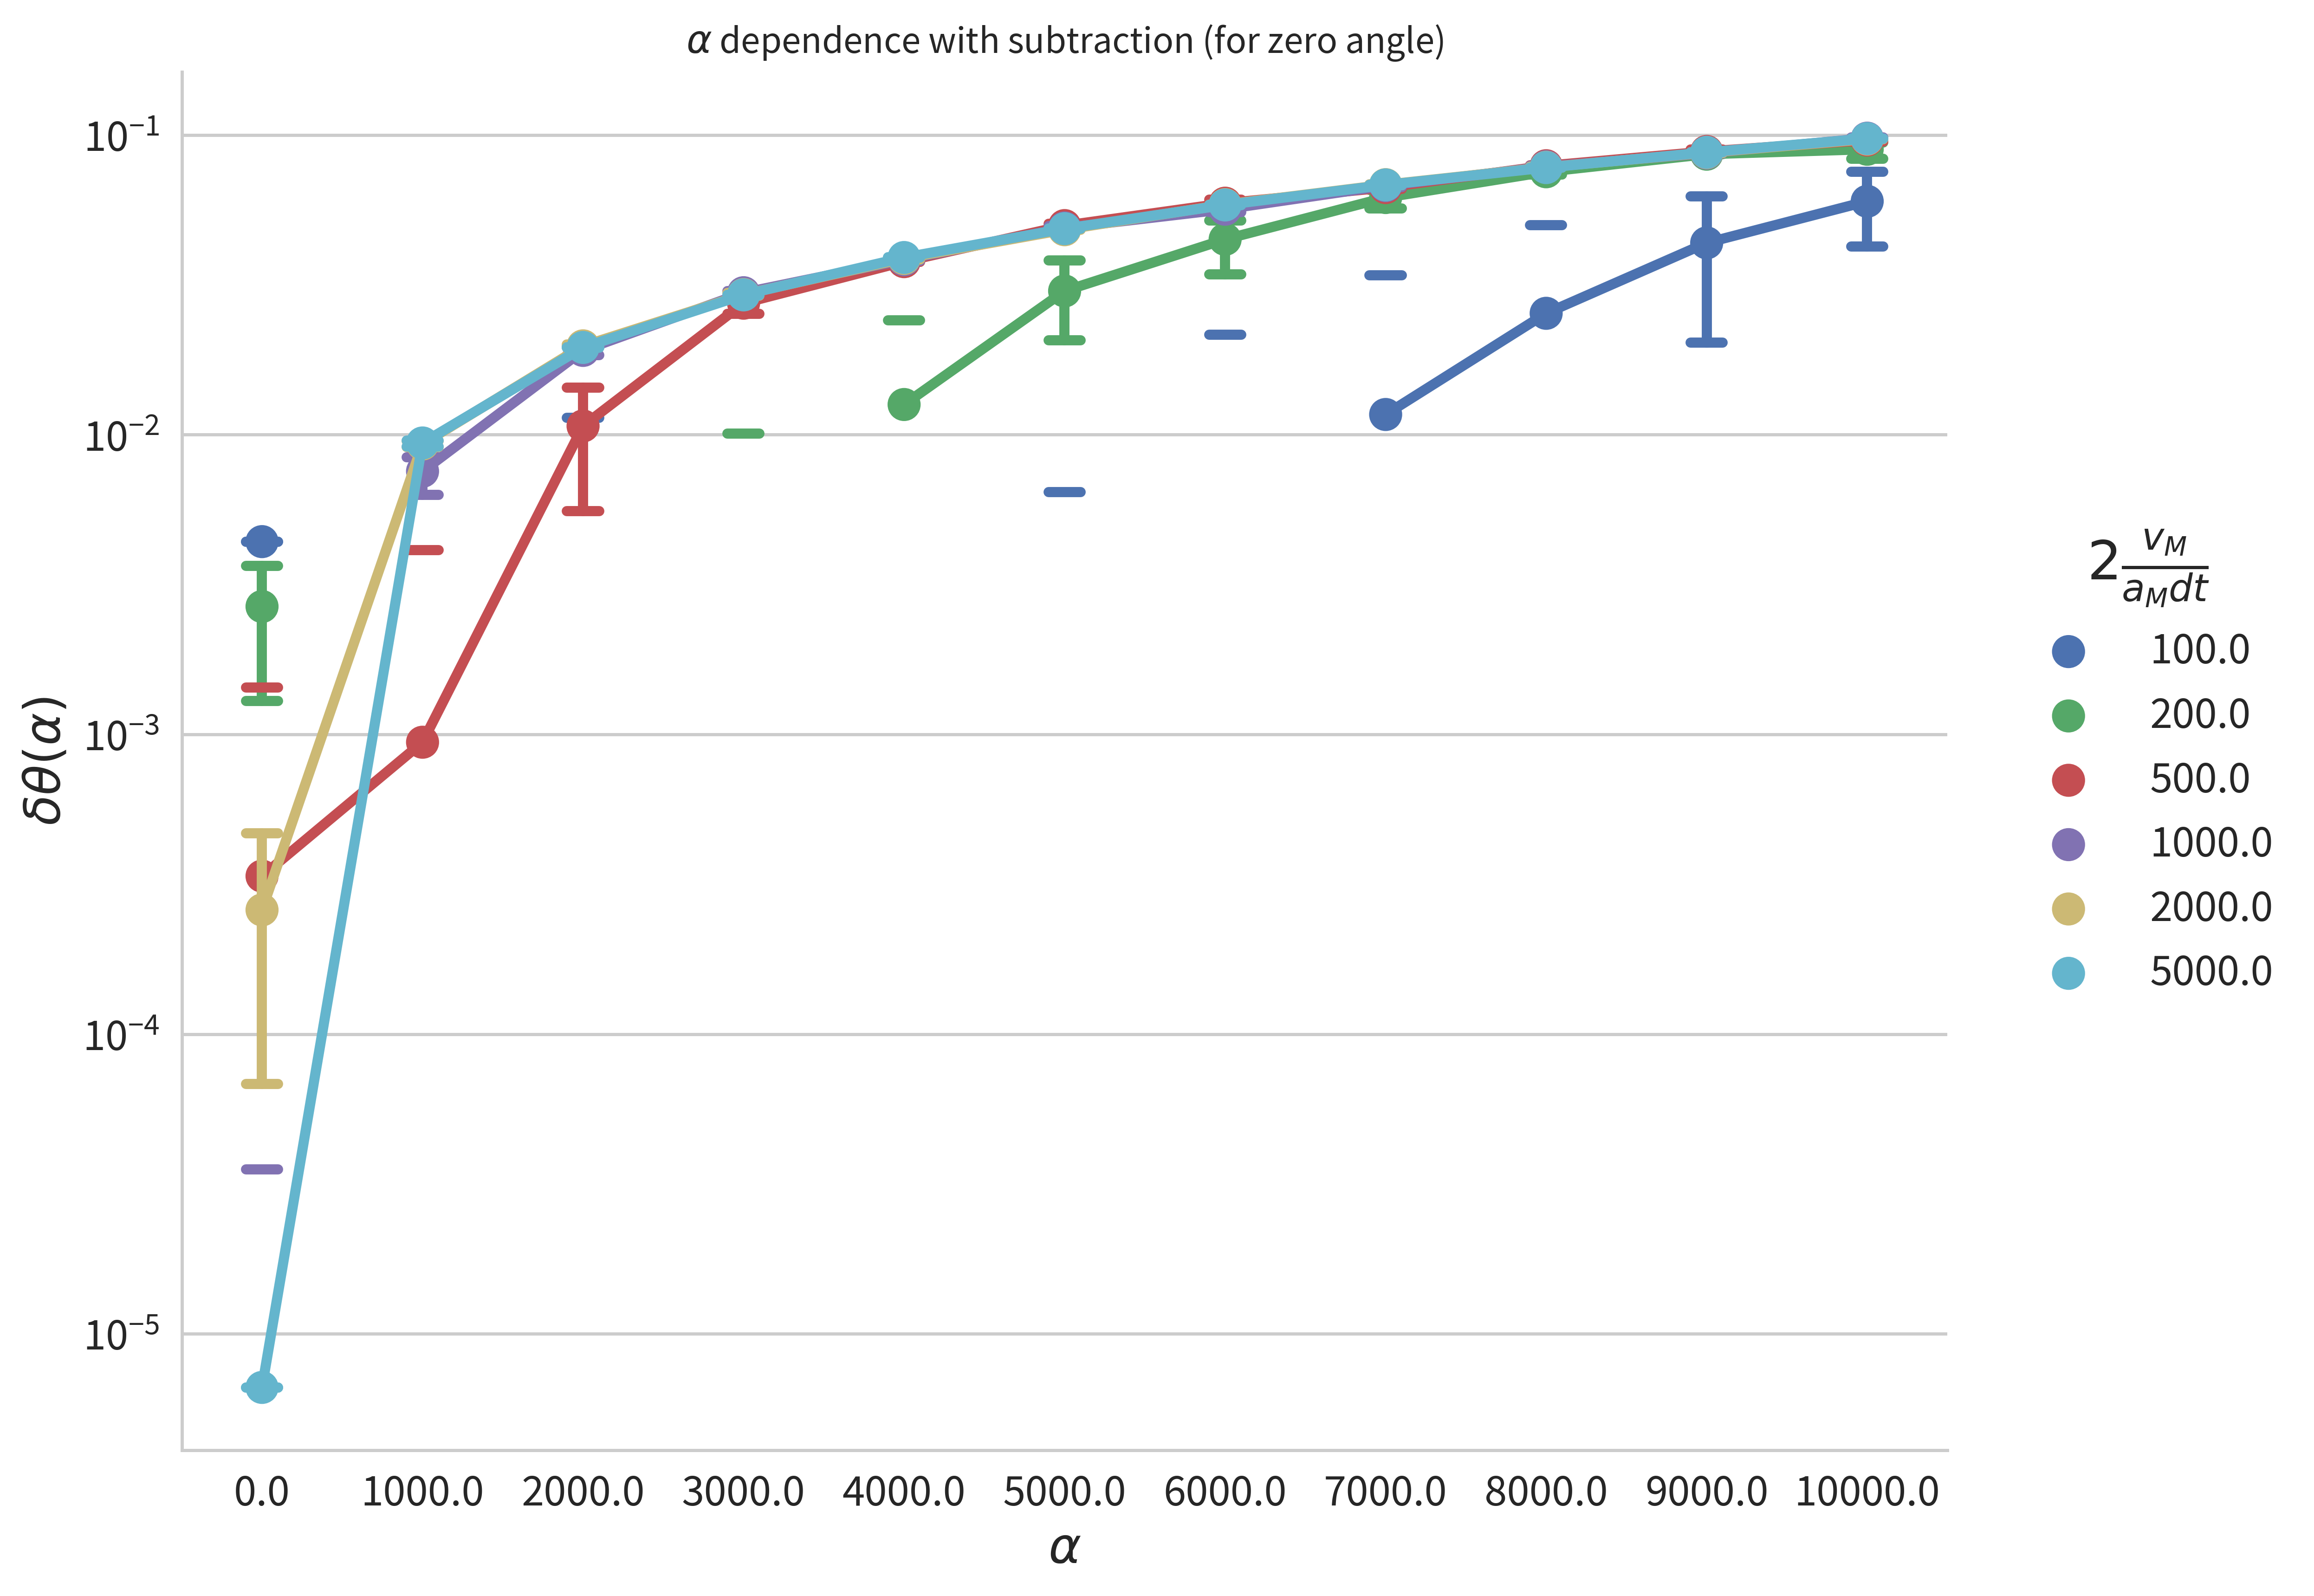

In [27]:
tf = frame.query("turn > 0").copy()
zeroa = frame.query("turn == 0 ")["dtheta"].as_matrix()

for turn in tf.turn.unique():
    ind = tf.query("turn == @turn").index
    tf.loc[ind,"dthpt"] = (tf.loc[ind,"dtheta"]- zeroa)/tf.loc[ind,"turn"]
#tf["dthpt"] = tf["dthpt"]/tf["turn"] * 356./88*100 *3600


graph = sns.factorplot(data=tf, x="alpha", y="dthpt", hue="dtfact", legend=False, capsize=.2)

graph.fig.set_dpi(500)
graph.fig.set_size_inches(12,8)

graph.set_axis_labels(r"$\alpha$",r"$\delta\theta(\alpha)$")
ax = graph.fig.gca()
ax.set_title(r"$\alpha$ dependence with subtraction (for zero angle)", fontdict={"size": 12})

#ax.set_xlim(-0.1, 2500)
#ax.set_ylim(-4000, 4002)

ax.set_yscale("log")

ax.legend(loc="center left", bbox_to_anchor=(1.02, 0.5), title=r"$2\frac{v_M}{a_M dt}$")

plt.show(graph)

In [278]:
graph.savefig("alpha_dependence_1.pdf", bbox_inches="tight")

In [280]:
"{0:1.2e}".format(356./88*100 *3600)

'1.46e+06'

# Old

## Plotting

In [355]:
import numpy as np
import seaborn as sns
import scipy.stats as stats
import re

sns.set(style="whitegrid", font="Source Sans Prop", font_scale=1.4)

Execute the loop as long as t < T

In [339]:
res = {}

for alpha in np.linspace(0, 1.e4, 11):
    t      = 0
    
    print alpha

    vec_rM = vec_rM0
    vec_vM = vec_vM0

    xpos = []
    ypos = []
    vx   = []
    vy   = []
    turns= []

    turn = 0
    theta = []
    while t < T*10.2:
        vec_rM, vec_vM = evolve_mercury(vec_rM, vec_vM, alpha)
        xpos.append(vec_rM.x)
        ypos.append(vec_rM.y)
        vx.append(vec_vM.x)
        vy.append(vec_vM.y)
        turns.append(turn)
        if len(xpos)>4:
              if xpos[-3]**2 + ypos[-3]**2 >= xpos[-2]**2 + ypos[-2]**2 <= xpos[-1]**2 + ypos[-1]**2:
                    turn += 1
                    theta.append(np.arccos( ypos[-2] /  np.sqrt(xpos[-2]**2 + ypos[-2]**2) )/turn/2/np.pi*360)
                    turns[-3] = turns[-2] = turns[-1] = turn

        t = t + dt
    res[alpha] = theta

turns = np.array(turns)
xpos = np.array(xpos)
ypos = np.array(ypos)
vx = np.array(vx)
vy = np.array(vy)

0.0
1000.0
2000.0
3000.0
4000.0
5000.0
6000.0
7000.0
8000.0
9000.0
10000.0


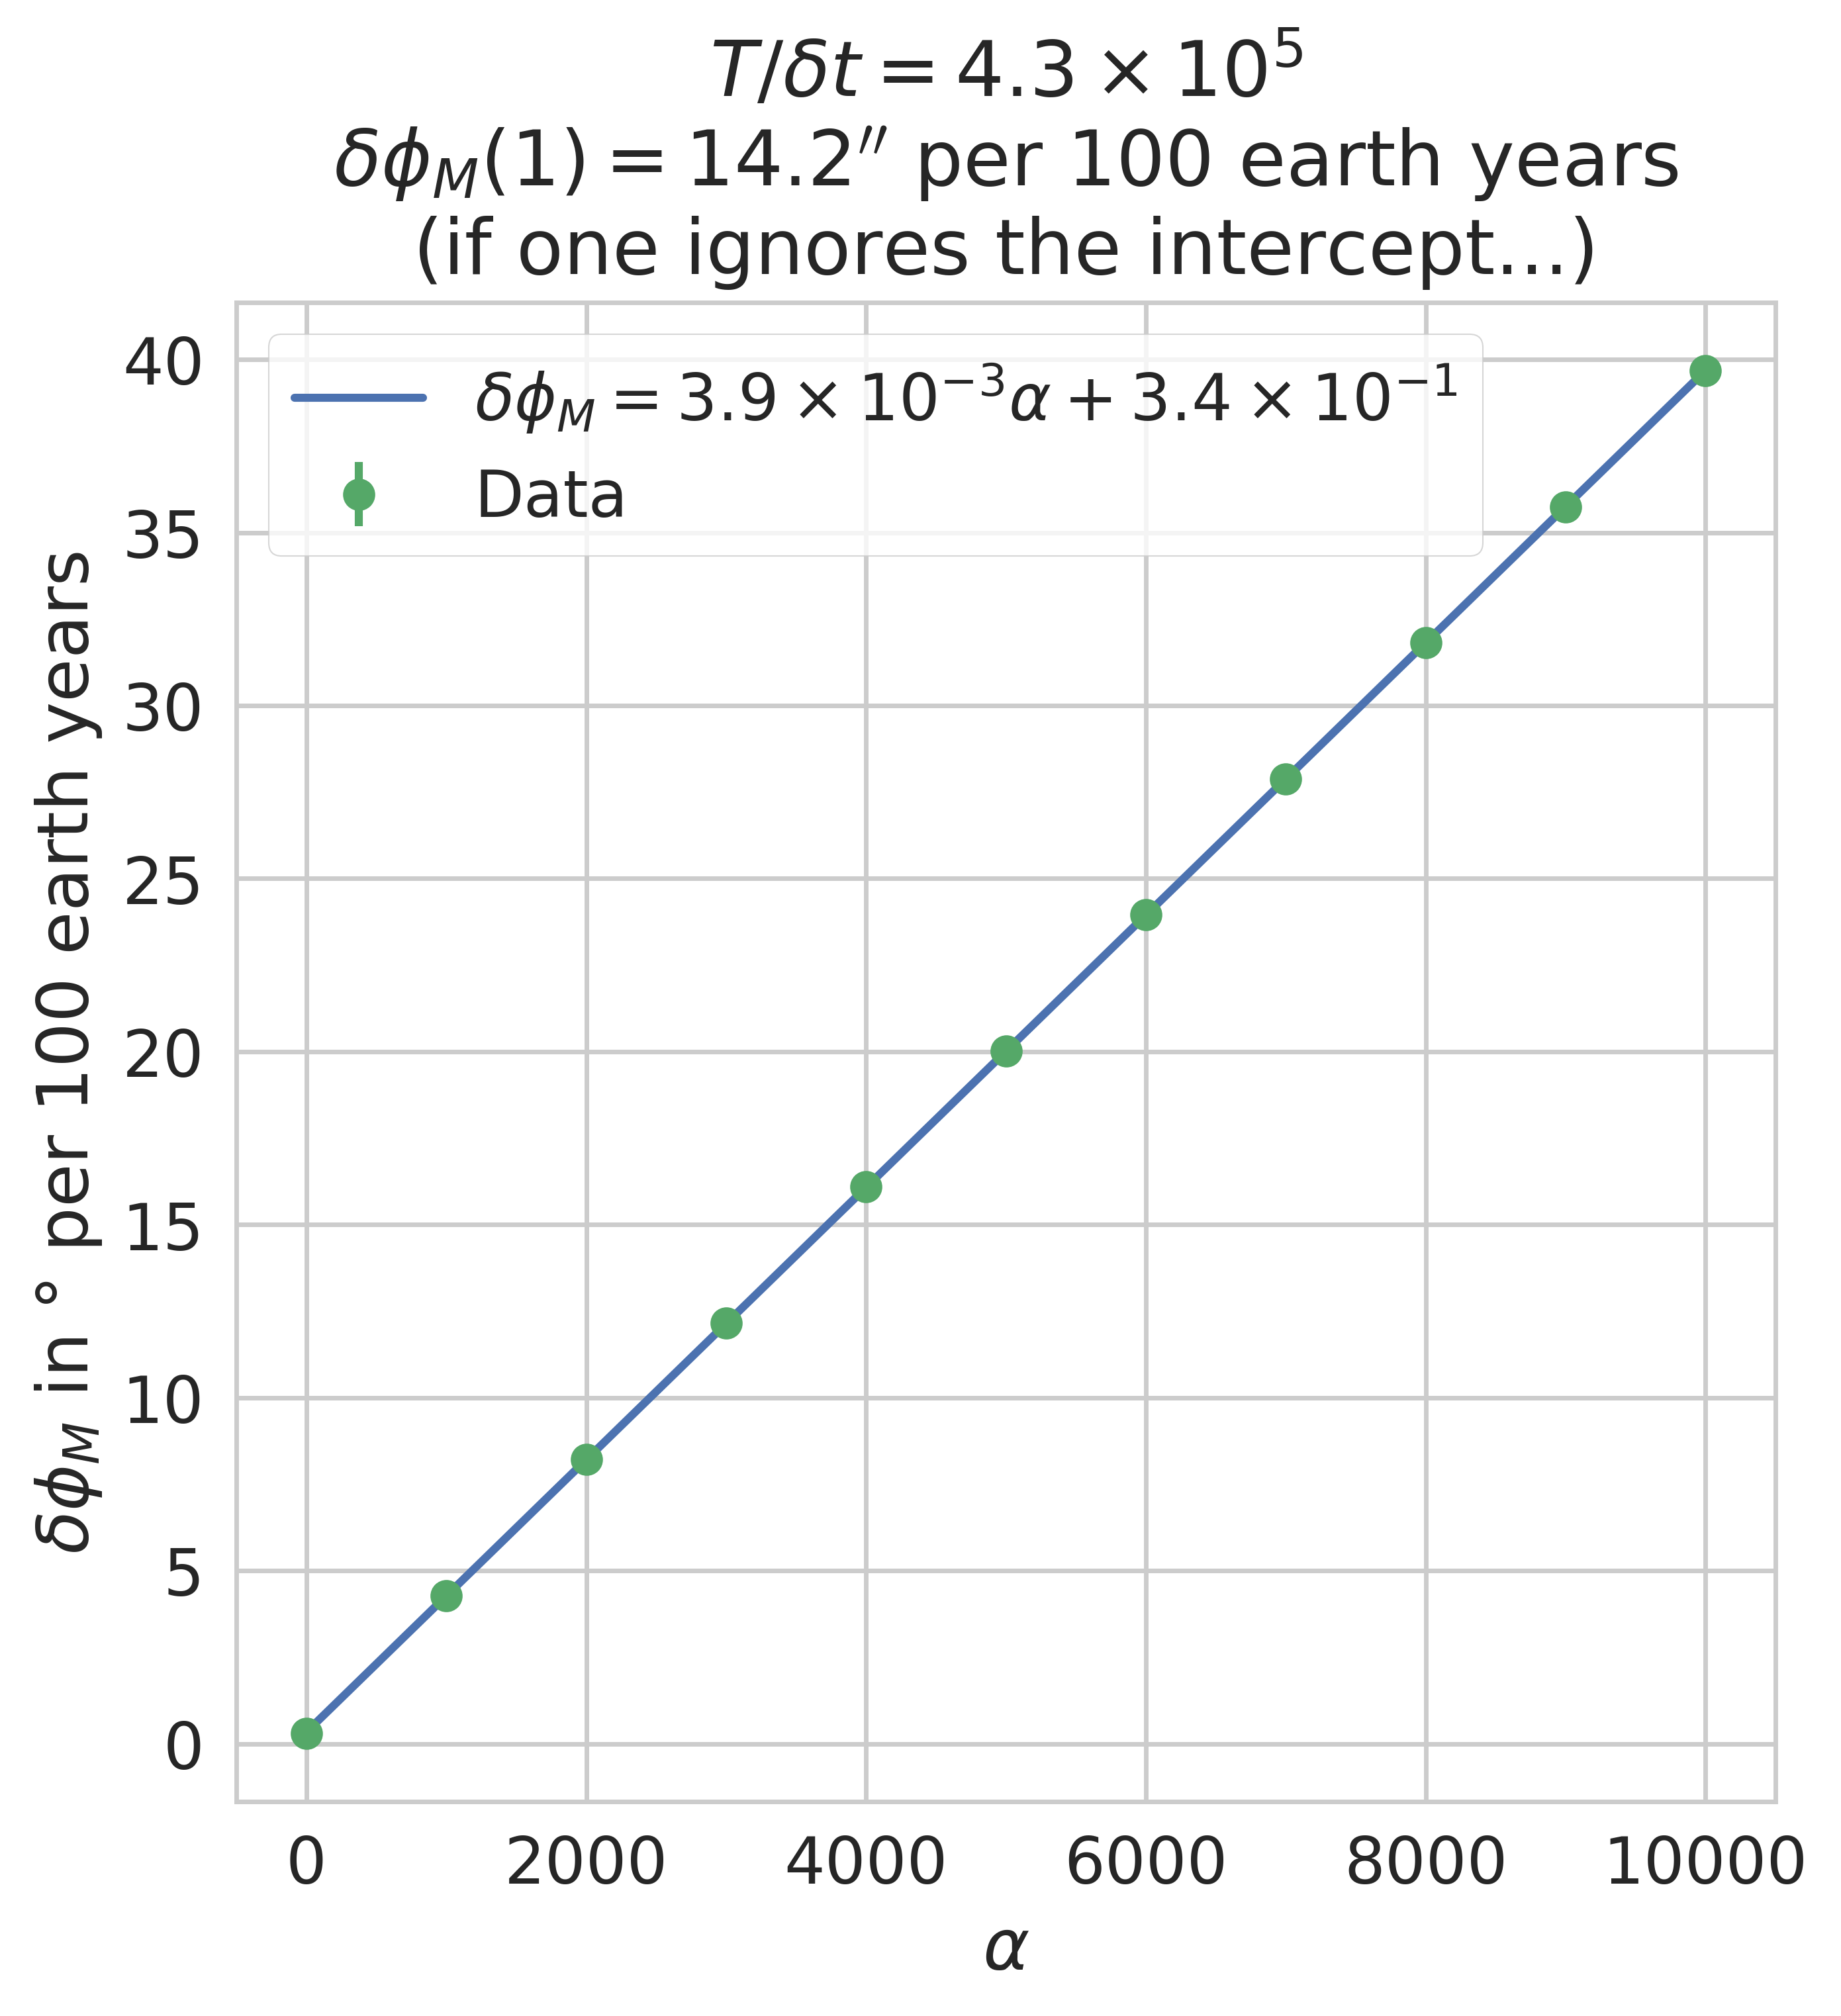

In [391]:
fig = sns.plt.figure(dpi=500, figsize=(6,6))

ax = fig.gca()

x, y = res.keys(), np.average(res.values(), axis=1)*356./88*100
dely = np.std(res.values(), axis=1)

slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)



xl = np.linspace(0, 1.e4, 200)

label = r"$\delta \phi _M = {m:1.1e}\alpha + {b:1.1e} $".format(m=slope, b=intercept).replace("0","")
label = re.sub(r"e([\+\-0-9]+)",r"\\times 10^{{\g<1>}}", label)

ax.plot(xl, intercept+slope*xl, label=label)
ax.errorbar(x, y, yerr=dely, marker="o", linestyle="None", label="Data")

sns.plt.legend(frameon=True, loc="upper left")

ax.set_xlabel(r"$\alpha$")
ax.set_ylabel(u"$\delta \phi _M$ in ° per 100 earth years")

title = ("$T / \delta t = {0:1.1e}$"+\
        "\n$\delta \phi _M(1) = {1:1.1f}''$ per 100 earth years").format(T/dt, slope*3600).replace("+0","") +\
        "\n(if one ignores the intercept...)"
title = re.sub(r"e([\+\-0-9]+)",r"\\times 10^{{\g<1>}}", title)

ax.set_title(title)

sns.plt.show()

In [392]:
fig.savefig("alpha_interpolation.pdf", bbox_inches="tight")

In [390]:
!open alpha_interpolation.pdf

In [326]:
r   = np.sqrt(np.array(xpos)**2 + np.array(ypos)**2)
phi = np.arccos( rM0*ypos / rM0 / r )
phi[xpos < 0] = - phi[xpos < 0] + 2*np.pi

In [262]:
for nel, el in enumerate(phi[1:]):
    if abs(el + 2*np.pi - phi[nel]) < abs(el - phi[nel]):
        phi[nel+1:] += 2*np.pi
        print nel+1, phi[nel+1]

74713 6.28321369688
149416 12.5664827297
224095 18.849638476
298739 25.1327482228
373338 31.4159839071
447879 37.6991877843
522350 43.9822996048
596742 50.2655033204
671044 56.5486968255
745248 62.831926237
819346 69.1150590918


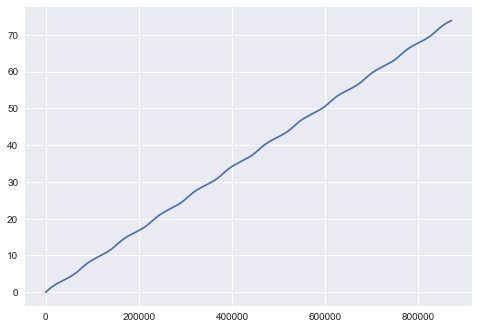

In [255]:
sns.plt.plot(phi)
sns.plt.show()

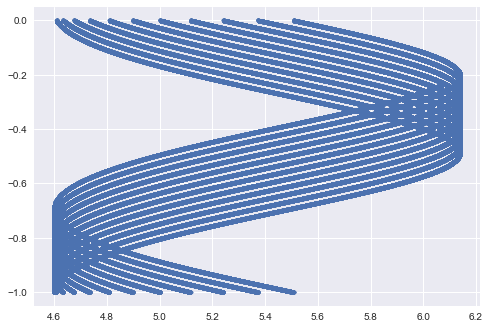

In [246]:
sns.plt.plot(r, phi/2/np.pi - 1. , ".")
sns.plt.show()

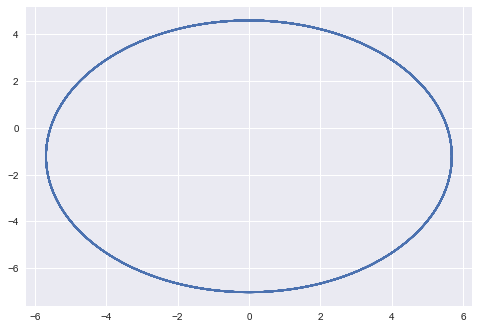

In [228]:
sns.plt.plot(xpos, ypos, "-")
sns.plt.show()

In [67]:
(xpos < 0).shape
(ypos < 0).shape
np.logical_and(xpos < 0, ypos < 0).shape

(854118,)